# Analisis exploratorio de los datos

# Liberias y DFs

In [247]:
#Importar librerias a usar
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import plotly.express as px
import zepid
from zepid.graphics import EffectMeasurePlot
import networkx as nx
from numpy import genfromtxt

#Creación de data frames a usar
df_metadata = pd.read_csv('..\data\cleaned\Tabla Normalizada - Metadata.csv')
df_data_type = pd.read_csv('..\data\cleaned\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('..\data\cleaned\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('..\data\cleaned\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('..\data\cleaned\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('..\data\cleaned\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('..\data\cleaned\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('..\data\cleaned\Tabla Normalizada - Performances.csv')
df_alg_perf = pd.read_csv('..\data\cleaned\Tabla Normalizada - Alg_Perf.csv')

# Set características generales de los gráficos

In [248]:
plt.rcParams['figure.figsize'] = [20, 10]

sns.set_style("whitegrid")
sns.set_palette('colorblind')

plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20

# Funciones
* multi_reversing = para casos donde un dato toma mas de valor, o en casos tipicos de one hot encoding (un dato toma un solo valor)
* multi_reversing_n = mismo que el anterior, pero para numeros distintos de cero


In [249]:
def multi_reversing(df,col_id, col_values):
    """la funcion toma nos da la frecuencia de los datos distribuidos en distintas columnas.
    Toma una variable distribuida en varias columnas (one hot encoding), y aplica la funcion melt para cambiar el formato
    de la tabla a long. Luego devuelve una columna donde aparece el nombre de cada columna, la cantidad de veces que fue
    marcada con una 'x' (si accuracy fue marcada 50 veces, aparecera el str 'accuracy' 50 veces, lo que permite graficar su frecuencia
    de aparicion)

    Args:
        df (dataframe): dataframe con el que se desea trabajar, debe poseer las columnas de id_vars y list_value_vars
        in_id_vars (str): nombre de la columna que se usa como identificador de variables 
        value_vars (str o lista): str o lista con el nombre de las columnas de las cuales se desea obtener los datos (se puede
        obviamente subsetear (p.e. dataframe.iloc['columna_1',...,columna_n']))

    Returns:
        dataframe: _description_
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value == 'x']

def multi_reversing_n(df,col_id, col_values):
    """exactamente lo mismo que multi_reversing, solo que para casos donde lo que se busca es un numero y no una x
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value != 0]

def bar_plot(col, data, titulos):
    var_x = col
    df = data
    g = sns.countplot(x=var_x, data=df, order = getattr(df, var_x).value_counts().index)
    g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
    plt.xticks(rotation=90)
    plt.show()

def t_student(x,y):
	print('Students t-test')
	from scipy.stats import ttest_ind
	stat, p = ttest_ind(x, y, alternative = 'greater')
	print('stat=%.3f, p=%.3f' % (stat, p))
	if p > 0.05:
		print('Probably the same distribution')
	else:
		print('Probably different distributions')

def mann_whitney_u(x,y):
	print('Mann-Whitney U Test')
	from scipy.stats import mannwhitneyu
	stat, p = mannwhitneyu(x, y, alternative = 'greater')
	print('stat=%.3f, p=%.3f' % (stat, p))
	if p > 0.05:
		print('Probably the same distribution')
	else:
		print('Probably different distributions')

# Gráficos

* La lista de los gráficos se encuentra en el README de esta carpeta (notebooks/README.md)

## 1. Gráfico de barra por año (2010-2020) por paper según modelos de emociones empleado (categoriales o dimensionales)

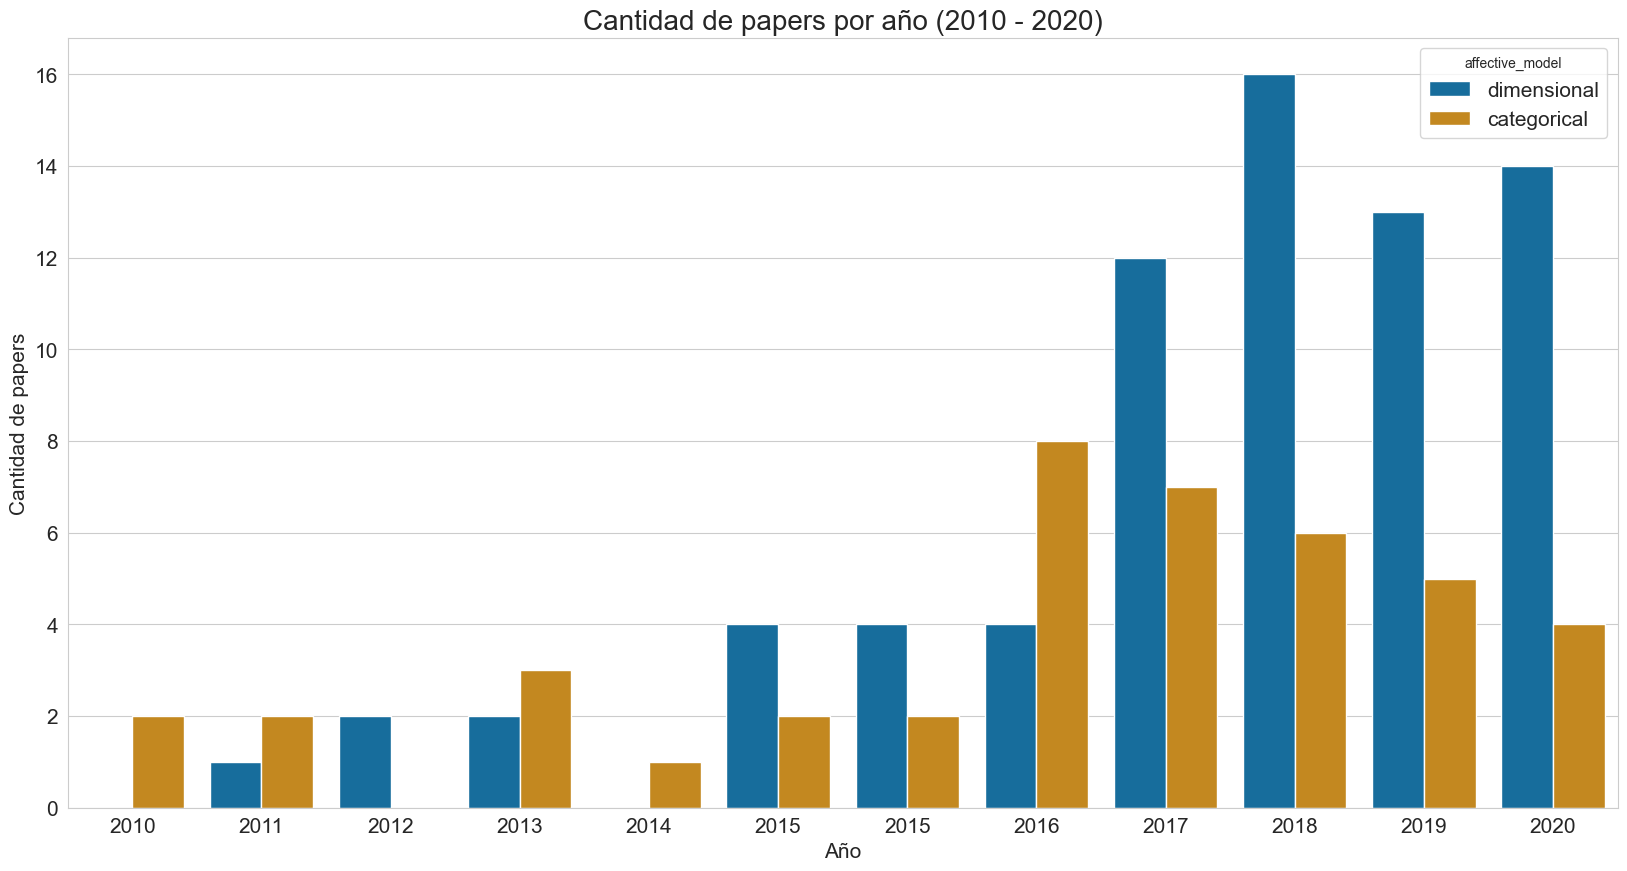

In [250]:
#rellenar datos faltantes y NO SE DROPEAN los duplicados (hay papers que usan multiples modelos)


df_statistical_learning_models=df_statistical_learning_models.fillna('-')
df_statistical_learning_models=df_statistical_learning_models[df_statistical_learning_models['affective_model'].isin(['categorical', 'dimensional'])]
df_statistical_learning_models_0 = df_statistical_learning_models.groupby(['paper_id','affective_model']).nth(0)
df_statistical_learning_models_0.reset_index(inplace=True)

#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_statistical_learning_models_0, 
    hue='affective_model', 
    order=category_order)
g.set(title = 'Cantidad de papers por año (2010 - 2020)', xlabel = 'Año', ylabel = 'Cantidad de papers')
#plt.savefig('..\\figures\\1. Cantidad de papers por año (2010-2020) segun tipo de modelo emocional.png')
plt.show()

## 2. Análisis estadístico para determinar si modelos de detección de arousal performan mejor que los basados en valence (Algoritmos de clasificación)
- Procedimiento: subsetear para quedarnos con modelos dimensionales(columna affective model), quedarse solo con clasificación binarias (LA,HA/LV,HV), quedarse con la medida de performance que mas aparezca. hacer el test estadístico correspondiente (t, wettney, etc), que depende del supuesto (si hay normalidad se aplica paramétrico, sino no-parametrico).
- Resultado: no existe diferencia estadisticamente significativa entre grupos, por lo que los algoritmos clasificadores basados en modelos dimensionales de clasificacion binaria (HA/LA, HV/LV) no performan mejor uno sobre otros (Segun t de student y u de mann-whitney).
- Tener en cuenta el tamaño de la muestra que cumple con todos los criterios mencionados en el Procedimiento: poco mas de 35 modelos en total.

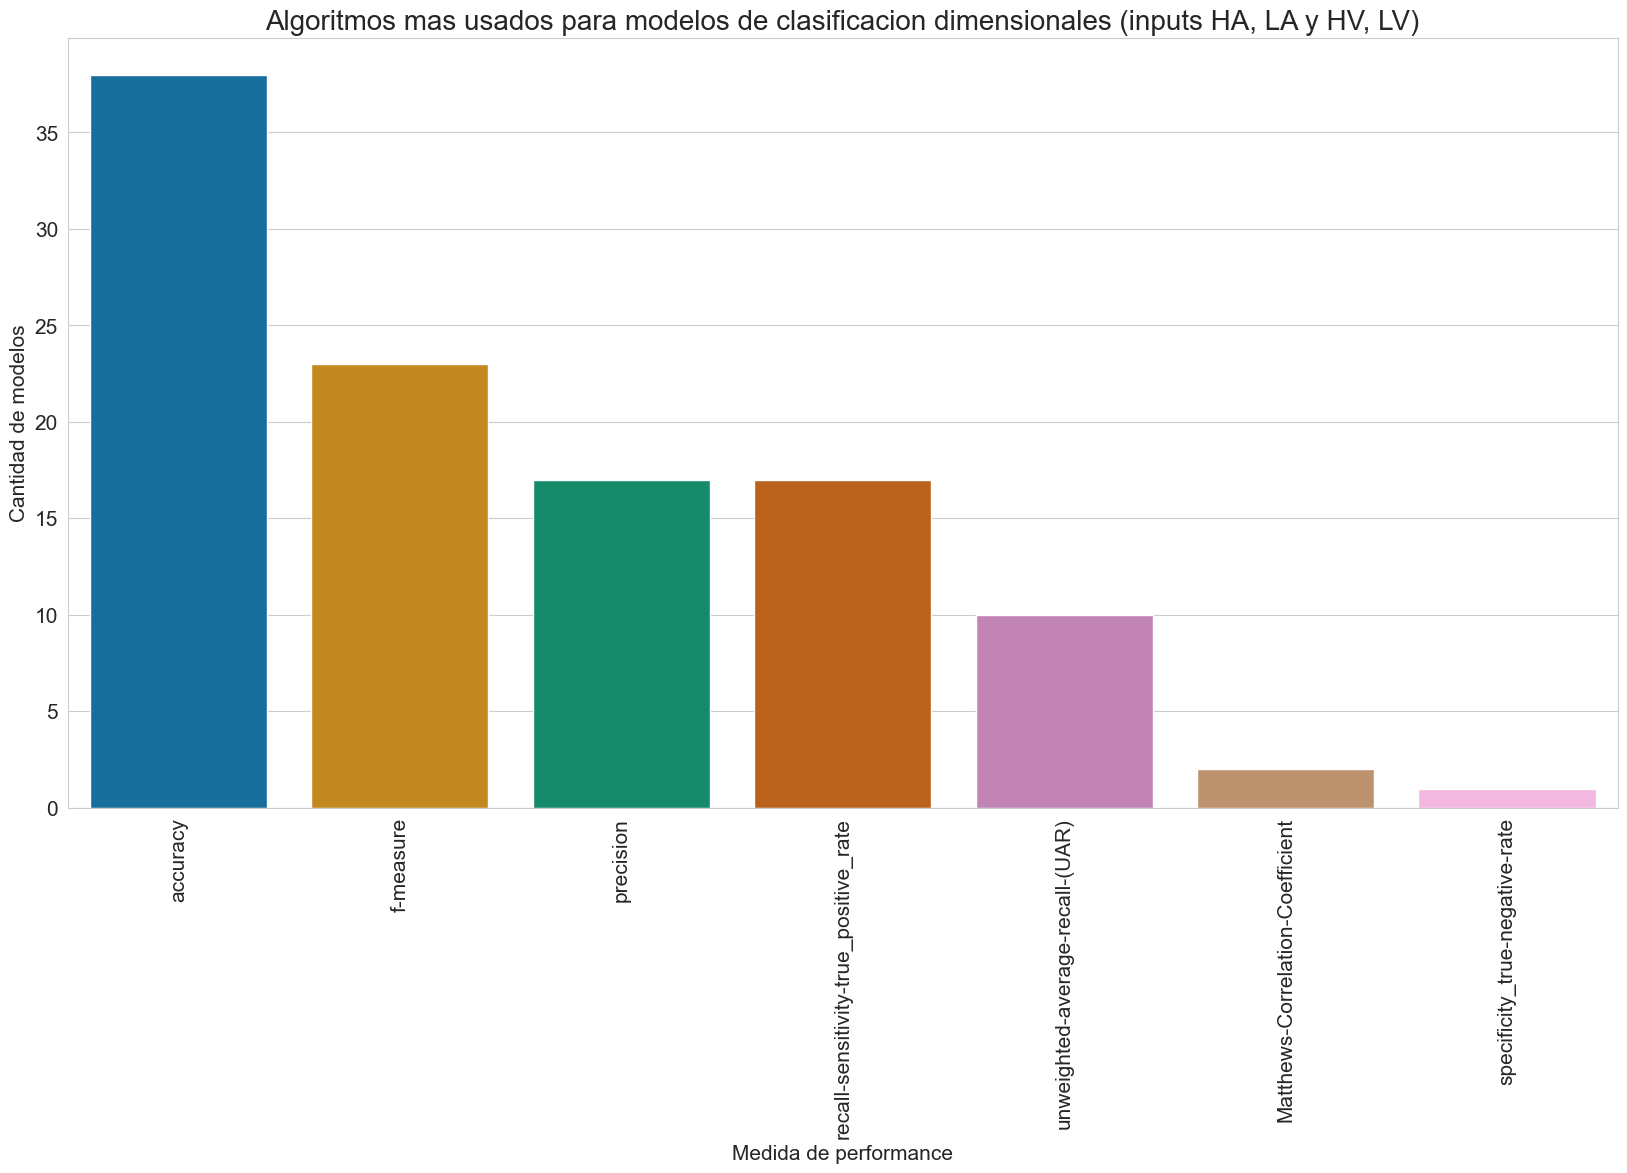

In [251]:
#creacion data frame y subseteo por: modelos dimensionales, tipo clasiffier, categorias HA/LA y HV/LV
df_alg_perf = df_alg_perf.fillna(0)
df_2 = df_alg_perf
df_2 = df_2[df_2['affective_model'] == 'dimensional']
df_2 = df_2[df_2['is_classifier'].isin(['x', 'X'])]
df_2 = df_2[df_2['class_model_output_categories'].isin(['HA, LA', 'HV, LV'])]

df2_performance_medidas = multi_reversing_n(df_2, 'model_id',df_2.iloc[:,57:])

titulos = ['Algoritmos mas usados para modelos de clasificacion dimensionales (inputs HA, LA y HV, LV)', 'Medida de performance', 'Cantidad de modelos']
bar_plot('variable',df2_performance_medidas,titulos)

#subseteo por la medida de performance que mas aparece (accuracy)
df_2 = df_2.fillna('-')
df_2 = df_2[df_2['accuracy'] != '-']

#print(df_2)

Aplicamos los estadísticos

obtenido de: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

In [252]:
#creacion lista con la performance para arousal y valence
df_arousal = df_2[df_2['class_model_output_categories'] == 'HA, LA']
df_arousal = df_arousal['accuracy']
arousal1 = df_arousal.values.tolist()
arousal1 = list(map(float, arousal1))

df_valence = df_2[df_2['class_model_output_categories'] == 'HV, LV']
df_valence = df_valence['accuracy']
valence1 = df_valence.values.tolist()
valence1 = list(map(float, valence1))

#print(arousal1, valence1)

#Test parametrico - t de student
t_student(arousal1, valence1)

#Test no parametrico - U de Mann-Whitney
mann_whitney_u(arousal1, valence1)


Students t-test
stat=0.349, p=0.364
Probably the same distribution
Mann-Whitney U Test
stat=430.500, p=0.260
Probably the same distribution


## 3. Gráficos frencuencia de los modelos algoritimicos, según modelos de regresión y clasificación

- Interpretaciones: Los algoritmos clasificadores son por mucho los mas usados, ademas de ser los que mas variedad representan. Que implica esto? Es lo mismo aplicar algoritmos clasificadores o regresores?
- Nota: ordenar los valores de los gráficos y unirlos en uno, buscar graficar los mas usados (primeros 5 o 10) 

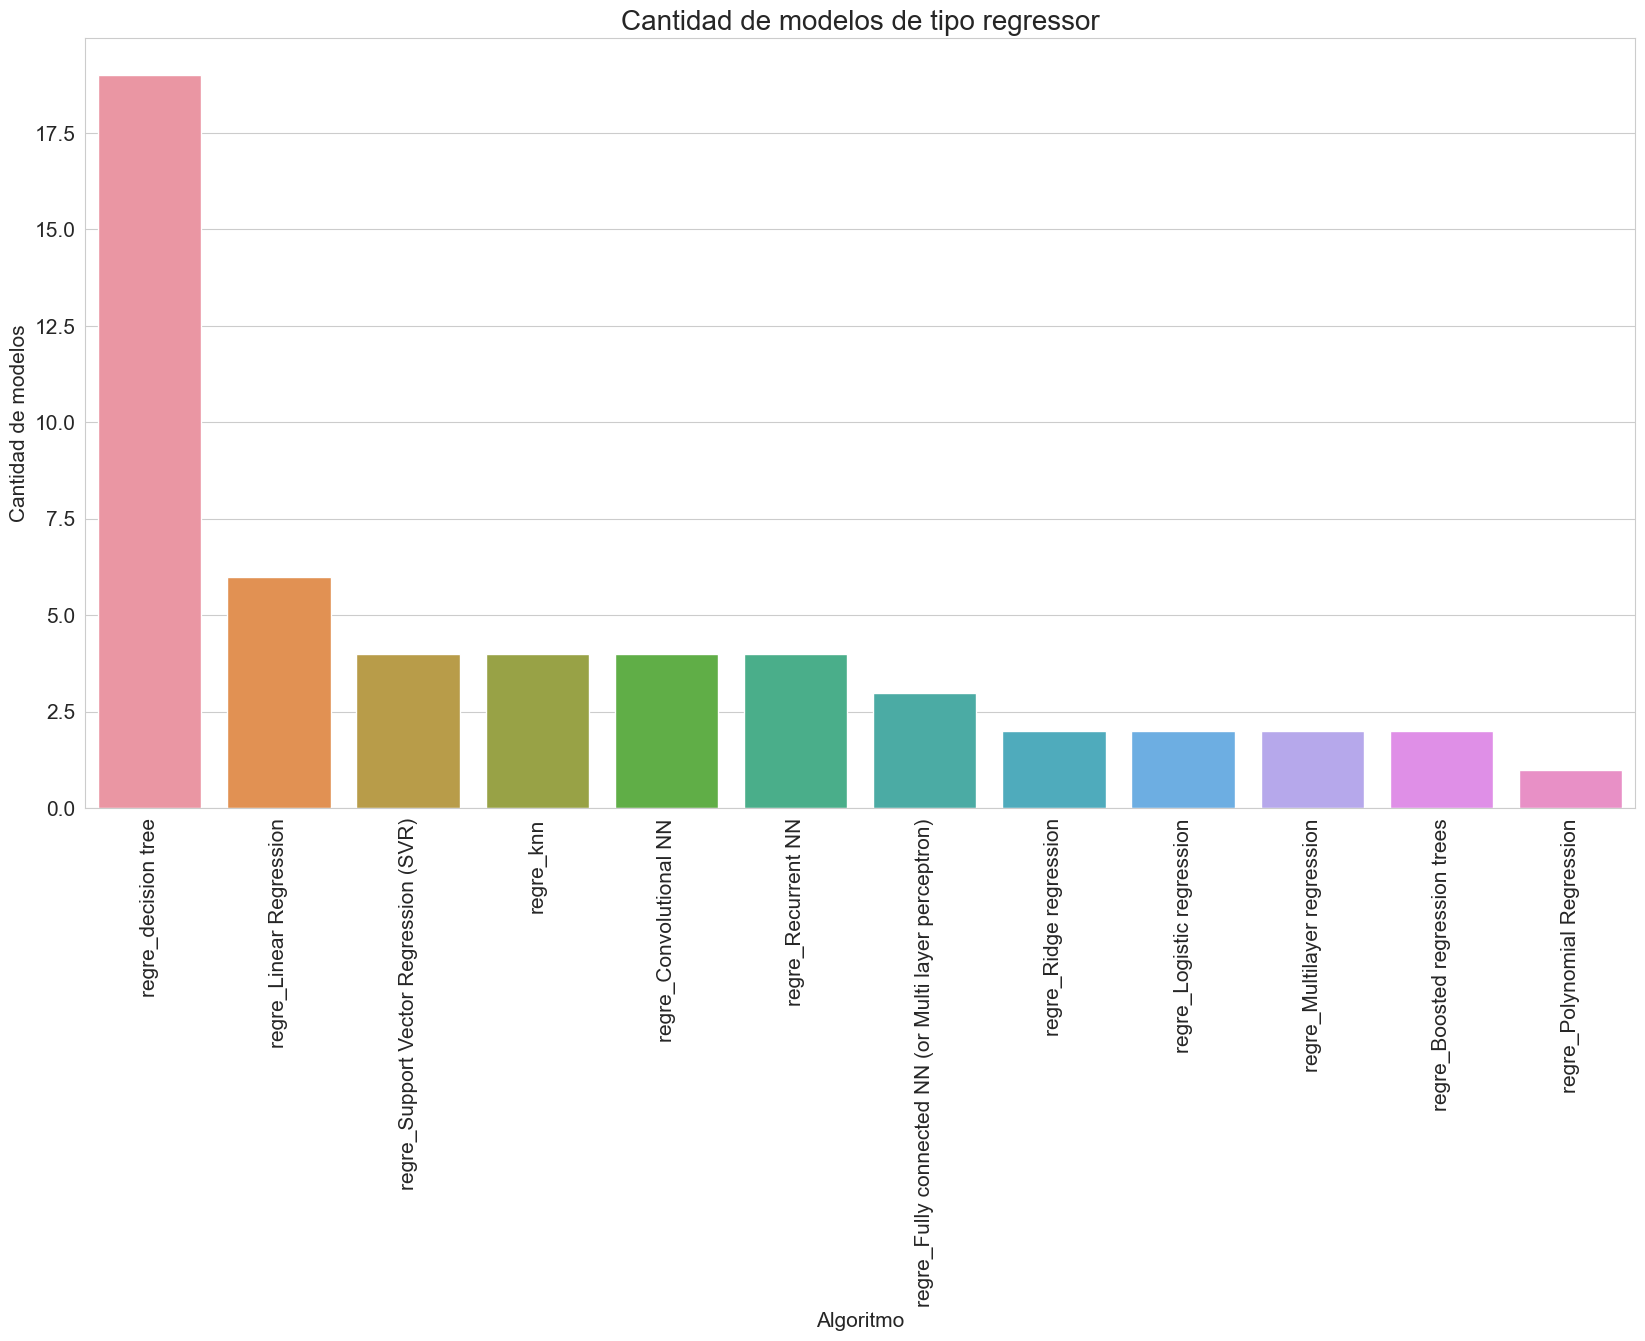

In [253]:
df_statistical_learning_models = df_statistical_learning_models.fillna('-')

#para regressor
df_algoritmos_regre = multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,43:57])

titulos = ['Cantidad de modelos de tipo regressor', 'Algoritmo', 'Cantidad de modelos']
bar_plot('variable',df_algoritmos_regre,titulos)

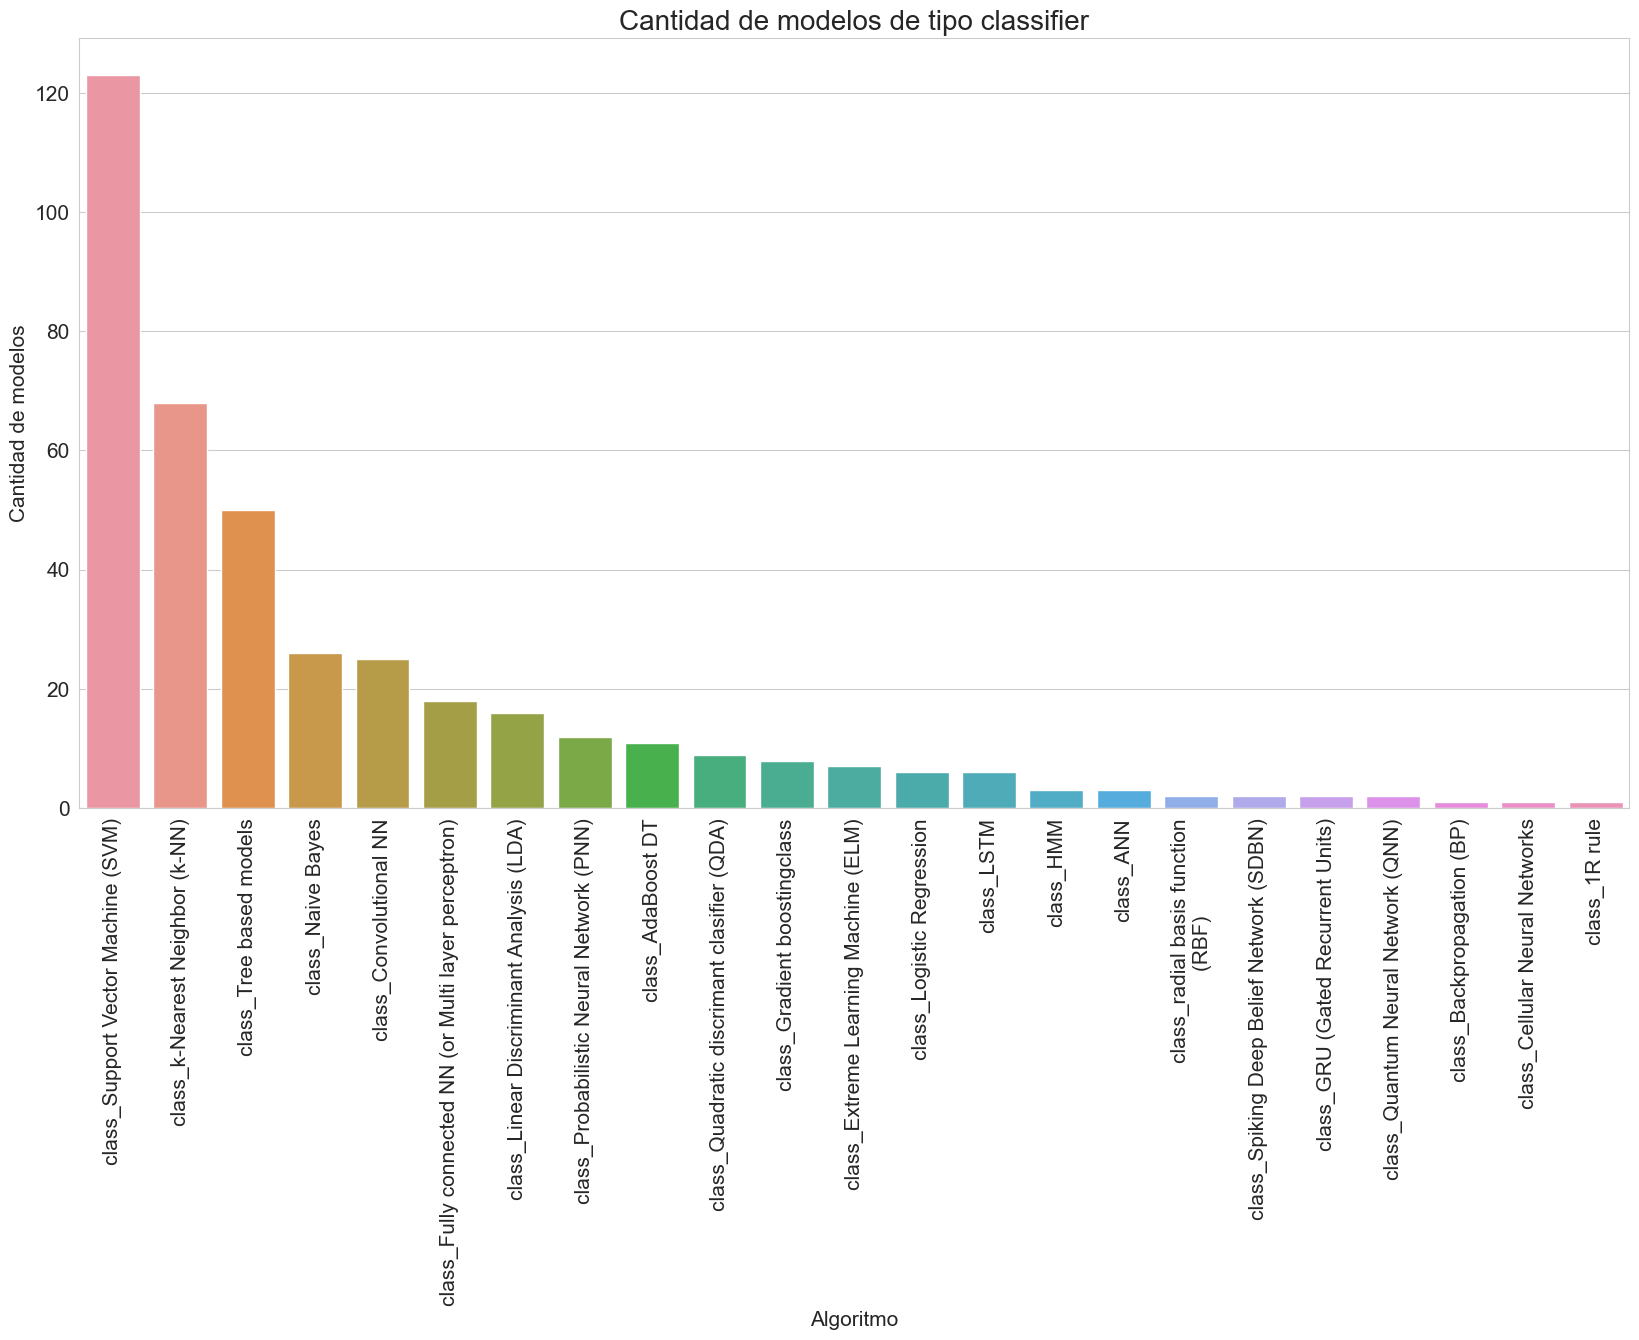

In [254]:
#para classifier

df_algoritmos_class = multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,8:40])

#Lista de algoritmos unicos de clasificacion
algoritmos_de_clasificacion = df_algoritmos_class["variable"].unique()
#print(algoritmos_de_clasificacion)

titulos = ['Cantidad de modelos de tipo classifier', 'Algoritmo', 'Cantidad de modelos']
bar_plot('variable',df_algoritmos_class,titulos)

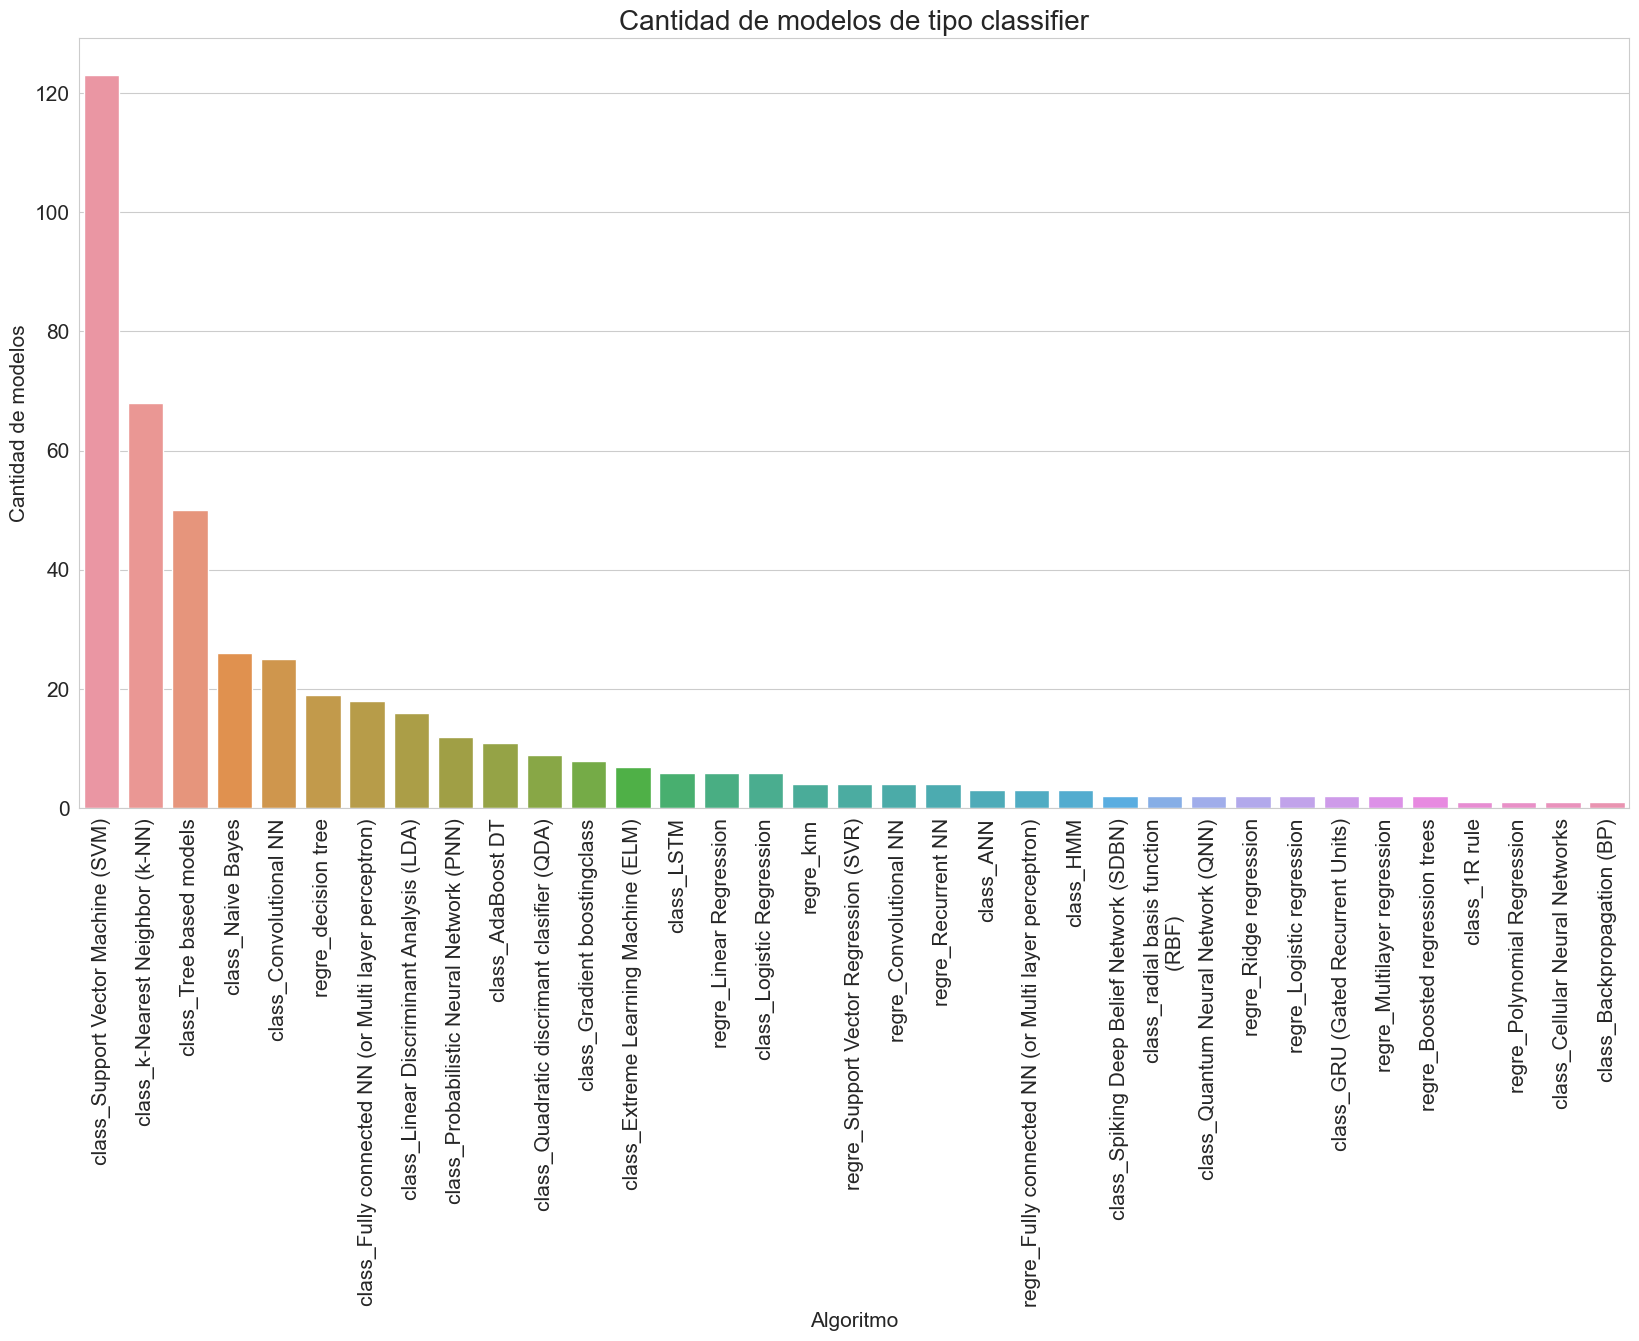

In [255]:
df_all_models = df_statistical_learning_models.iloc[:,1:57]
df_all_models.drop(df_all_models.columns[[1,2,3,4,5,6,39,40,41]], axis=1, inplace=True)

df_all_models = multi_reversing(df_all_models, 'model_id', df_all_models.iloc[:,1:])

titulos = ['Cantidad de modelos de tipo classifier', 'Algoritmo', 'Cantidad de modelos']
bar_plot('variable',df_all_models,titulos)




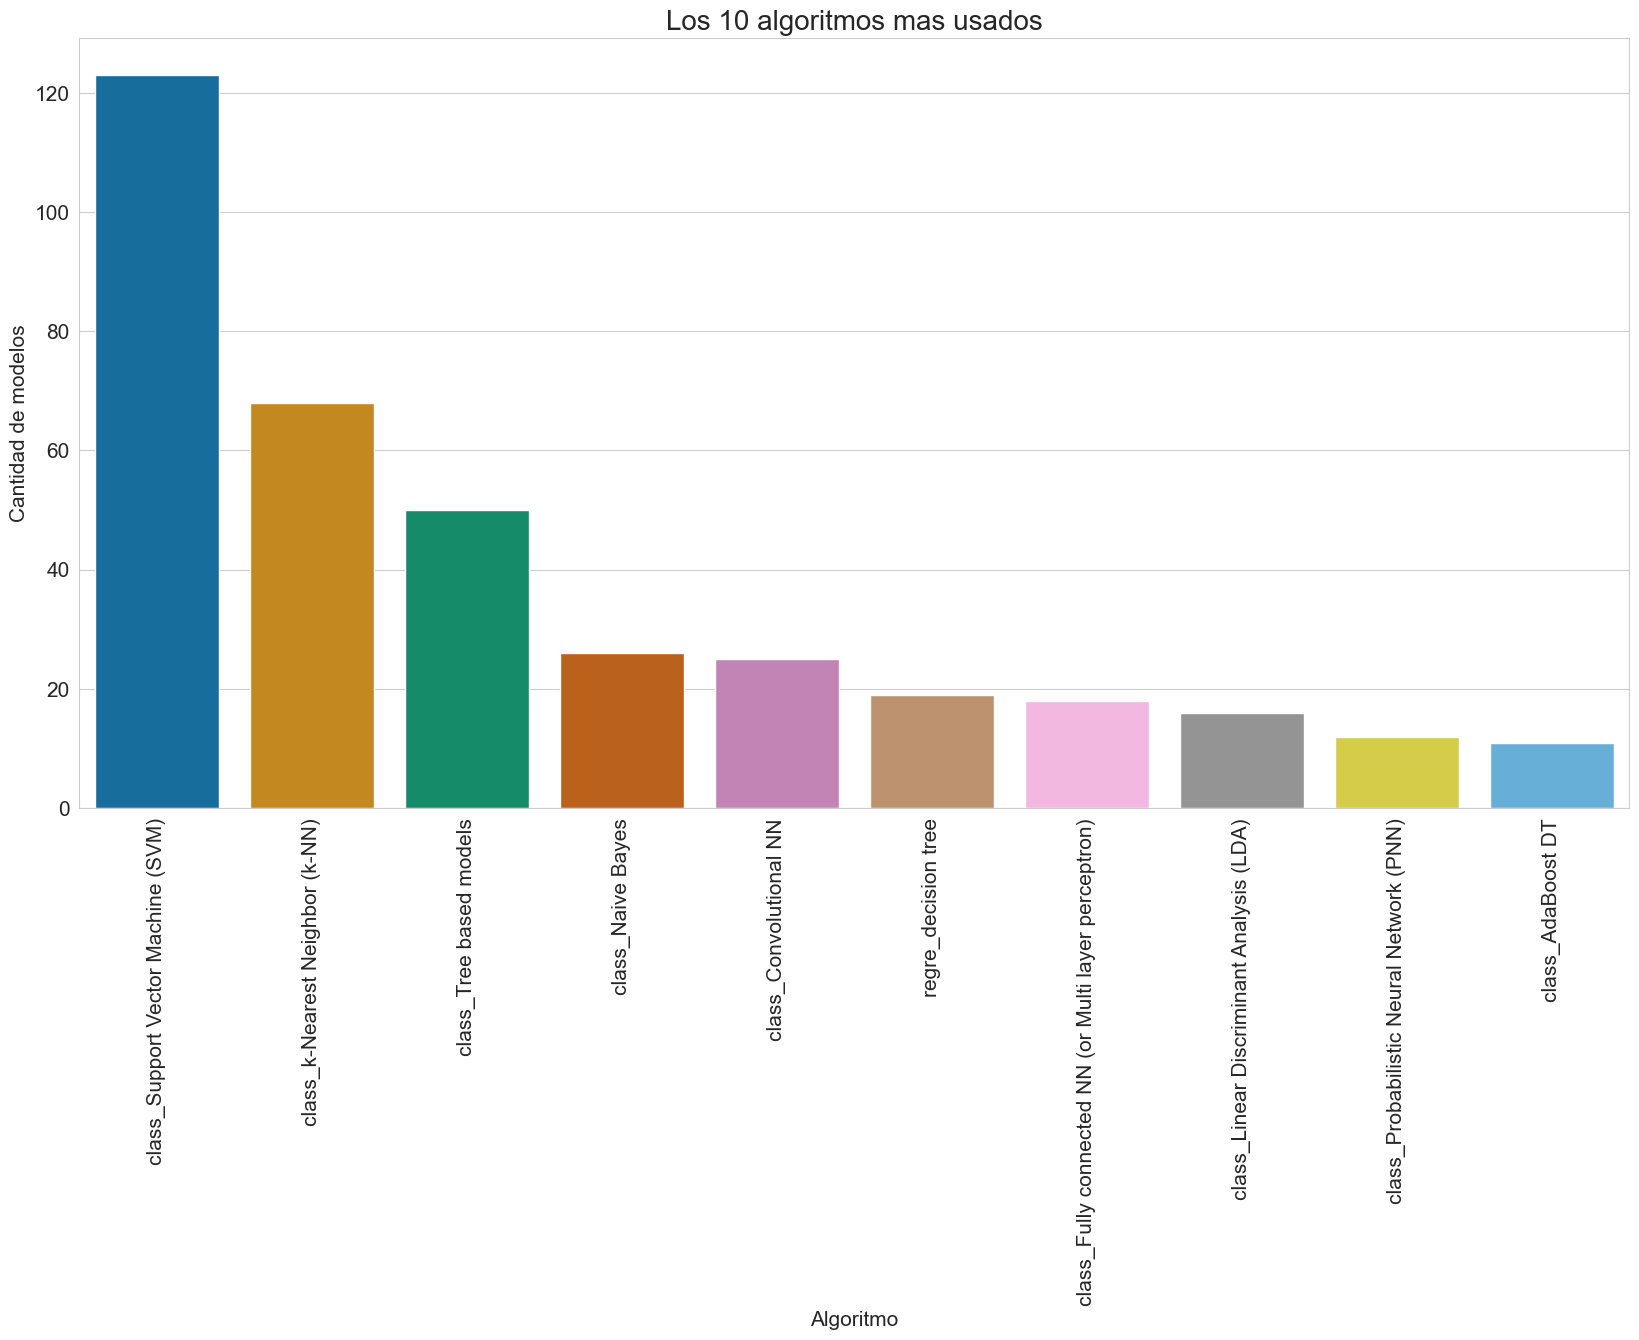

In [256]:
vc = df_all_models['variable'].value_counts()
vc = vc.iloc[:10]
df_dv = vc.to_frame()
df_dv = df_dv.reset_index()
df_dv.rename(columns = {'index':'algoritmo', 'variable':'cantidad'}, inplace = True)

titulos = ['Los 10 algoritmos mas usados', 'Algoritmo', 'Cantidad de modelos']
g = sns.barplot(data=df_dv, x='algoritmo', y='cantidad')
g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
plt.xticks(rotation=90)
plt.show()

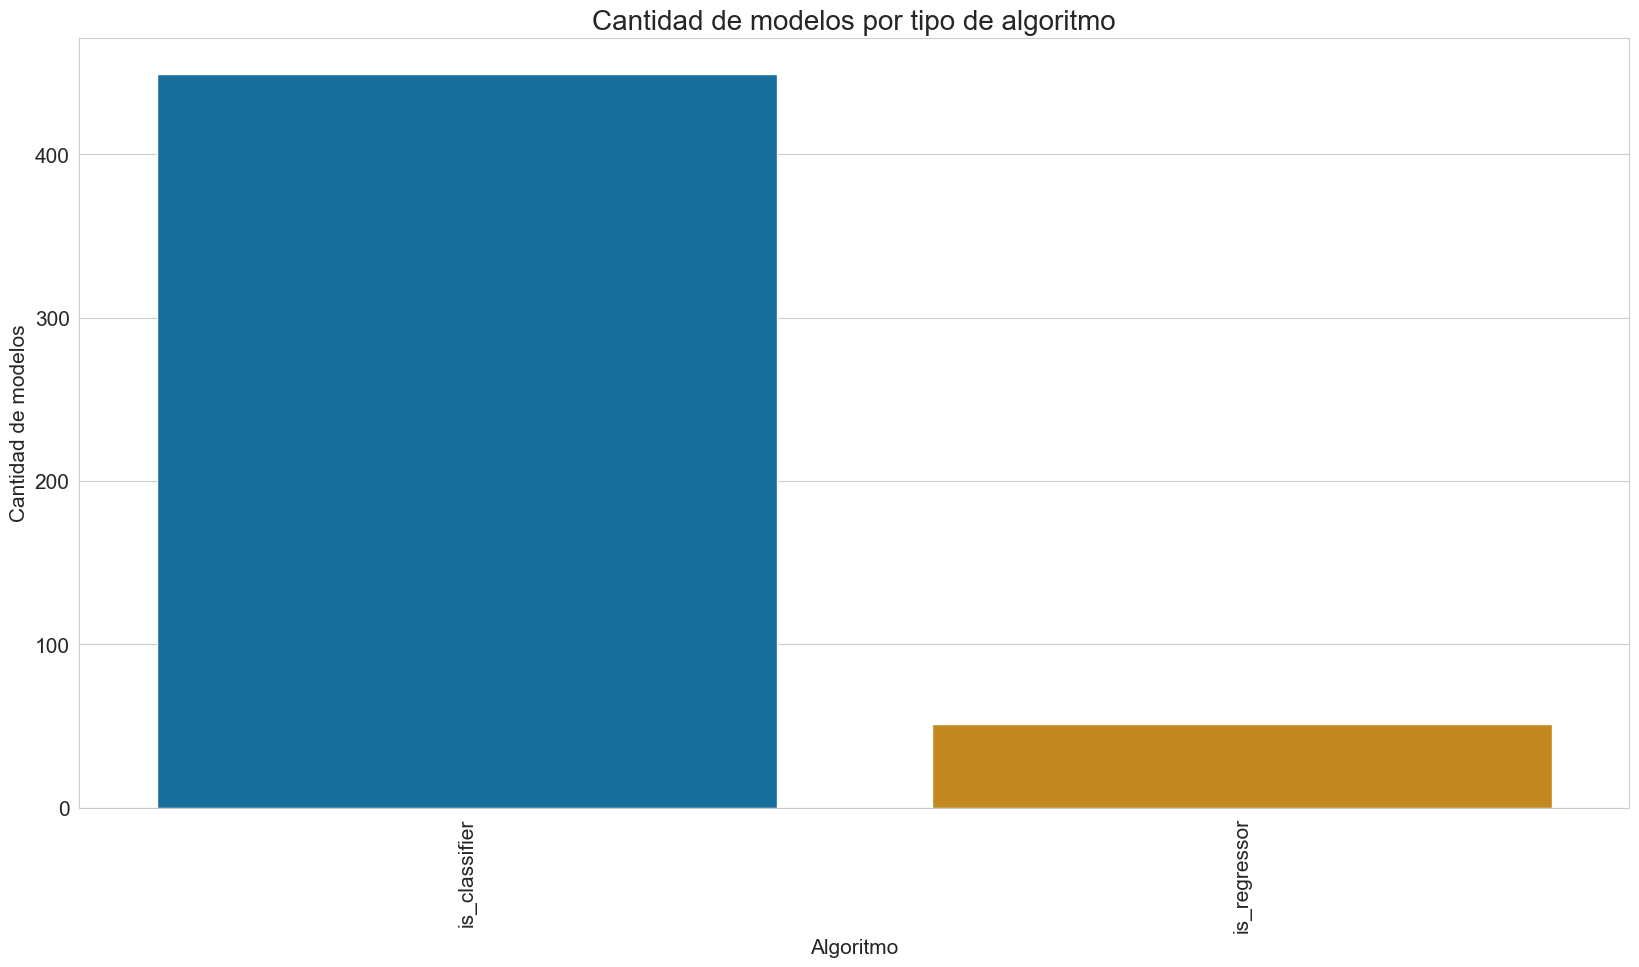

In [257]:
#cantidad de algoritmos de regresion y clasificacion
df_class_or_regre = multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,[5,40]])
"""print(df_class_or_regre)
print(df_class_or_regre["variable"].value_counts())"""
titulos = ['Cantidad de modelos por tipo de algoritmo', 'Algoritmo', 'Cantidad de modelos']
bar_plot('variable',df_class_or_regre,titulos)


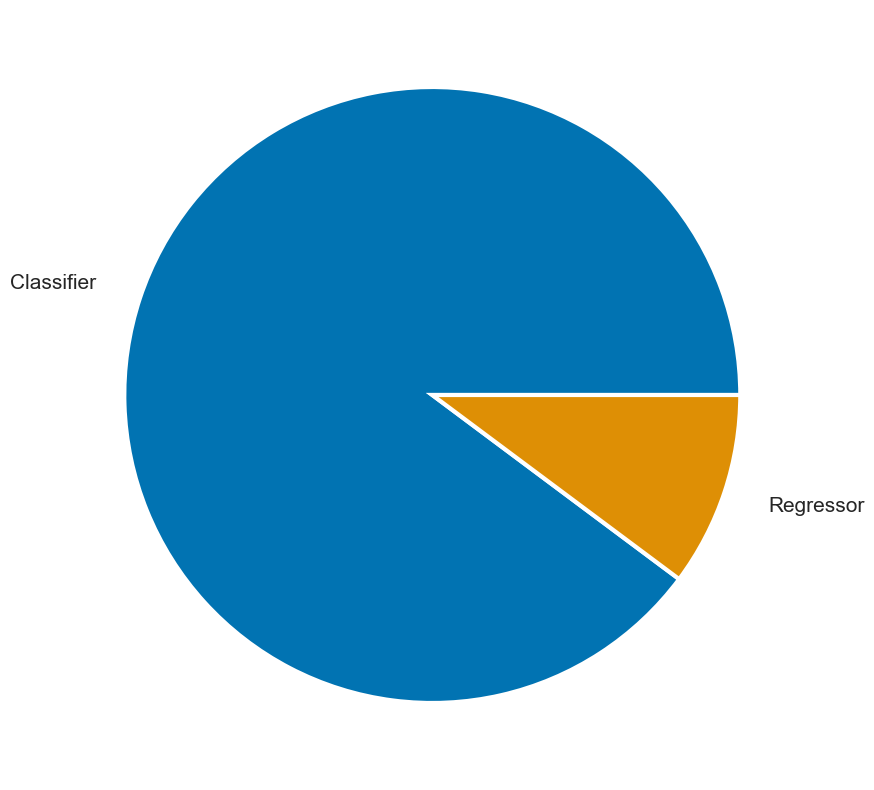

In [258]:
#pie plot
quantity = df_class_or_regre['variable'].value_counts()
df_class_or_regre_quantity = pd.DataFrame(quantity)

names = 'Classifier', 'Regressor'
plt.pie(df_class_or_regre_quantity['variable'], labels = names, labeldistance = 1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.show()

## 3.5 Cantidad de modelos de regresion o categorial por anio

In [259]:
def label_model (row):
   if row['is_classifier'] == "x" :
      return 'classifier'
   if row['is_regressor'] == "x" :
      return 'regressor'
   return 'Other'

In [260]:
df_statistical_learning_models['model']  = df_statistical_learning_models.apply(lambda row: label_model(row), axis=1)

In [261]:
df_models = df_statistical_learning_models[["apa_citation",'model', "year", "model_id"]]

In [262]:
df_models[df_models['model'].isin(['Other'])]

,apa_citation,model,year,model_id
258,"Kostoulas, T., Chanel, G., Muszynski, M., Lomb...",Other,2017.0,259.0
309,"Al Machot, F., Elmachot, A., Ali, M., Al Macho...",Other,2019.0,310.0
359,"Wei, W., Jia, Q., Feng, Y., & Chen, G. (2018)....",Other,2018.0,360.0
430,"Niu, Y., Wang, D., Wang, Z., Sun, F., Yue, K.,...",Other,2020.0,431.0
452,"Liapis, A., Katsanos, C., Karousos, N., Xenos,...",Other,2019.0,453.0


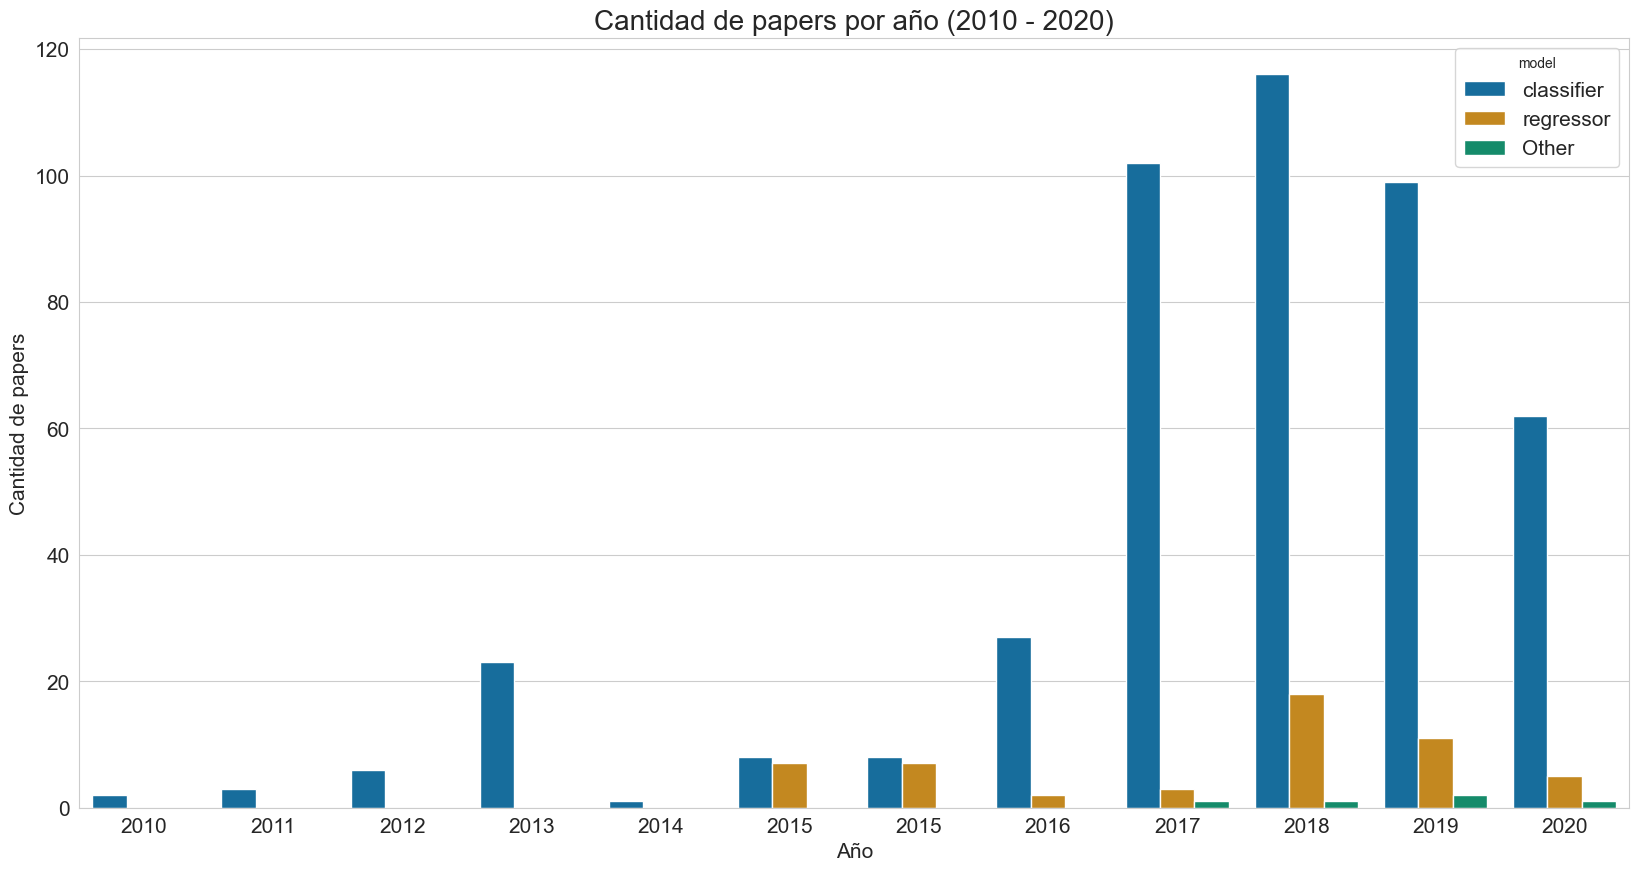

In [263]:
#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_models, 
    hue='model', 
    order=category_order)
g.set(title = 'Cantidad de papers por año (2010 - 2020)', xlabel = 'Año', ylabel = 'Cantidad de papers')
plt.show()

## 4. Emotion elicitation techniques

Nota: Falta organizar bien la data en la tabla, para obtener las siguientes barras: multimodal, modalidad visual, mod auditory, mod somatosensory

## 5. Gráfico de barra por año (2010-2020) según tipos de base de datos (privada, pública)

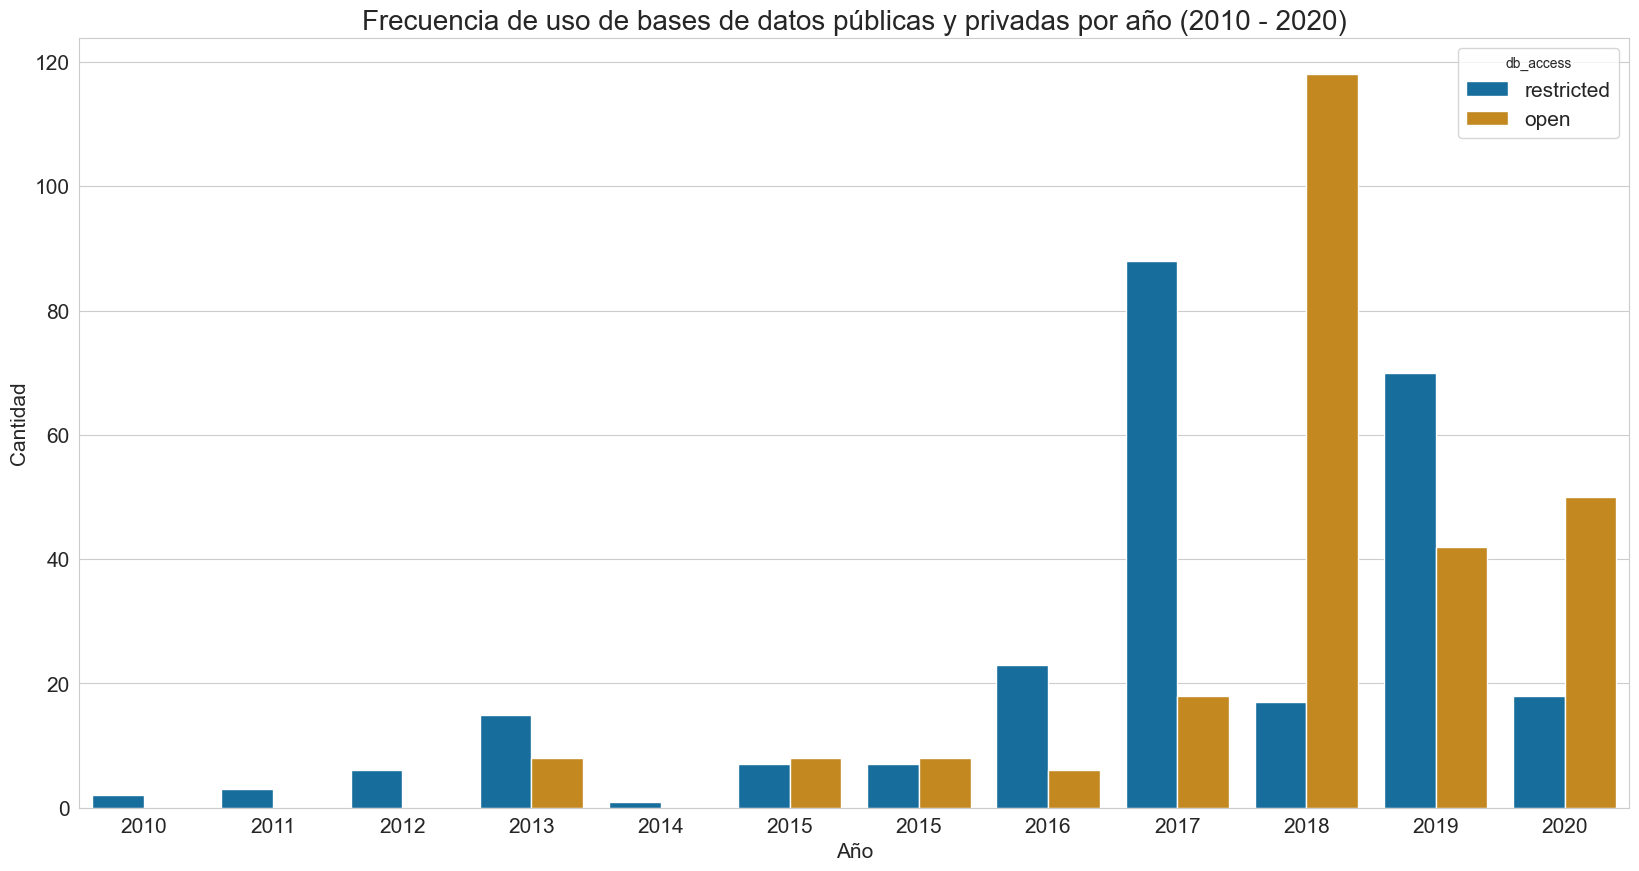

In [264]:
#rellenar datos faltantes y dropeo de duplicados
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g = sns.countplot(x='year', 
    data= df_data_type, 
    hue='db_access', 
    order=category_order)
g.set(title = 'Frecuencia de uso de bases de datos públicas y privadas por año (2010 - 2020)', xlabel = 'Año', ylabel = 'Cantidad')
plt.show()

## 6. Gráfico frencuencia de uso de cada base de datos pública encontrada
- Interpretacion: Un predominio de pocas bases de datos. Estamos todo el tiempo sacando conclusiones sobre los mismos sujetos? Ver predominio de bases de datos publicas por sobre las privadas
- No se ha tenido en cuenta el dato aportado por Lorenzo (mas de una db por paper)

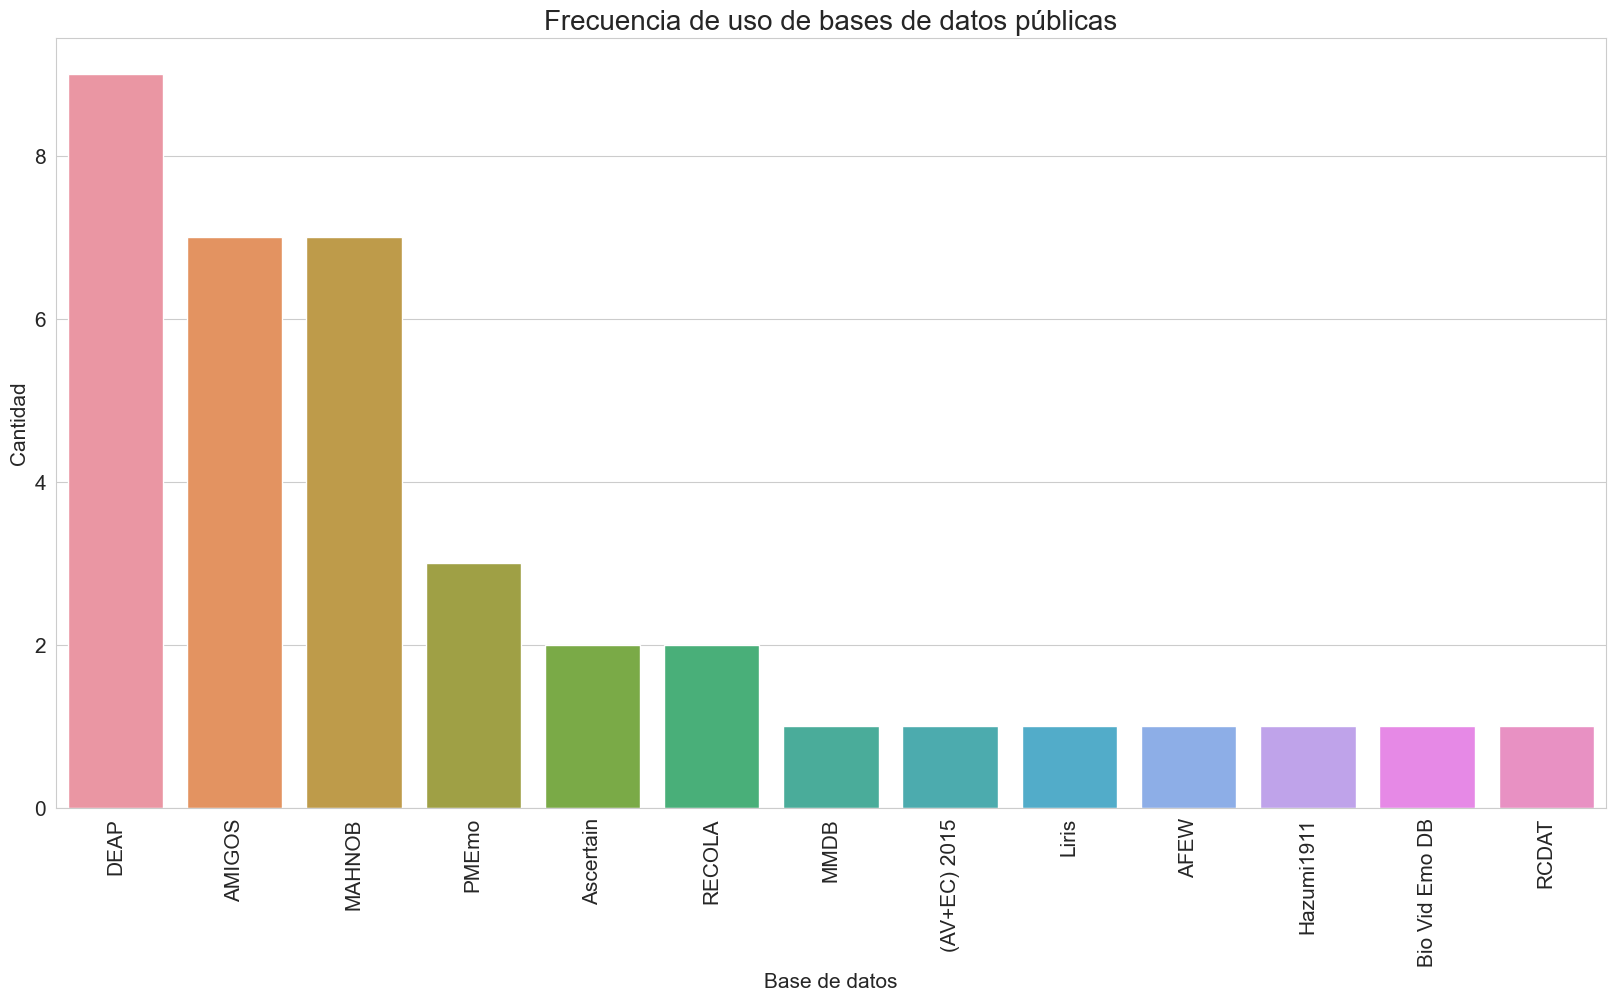

In [265]:
#bases de datos
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

df_db = multi_reversing(df_data_type_sin_duplicates, 'paper_id', df_data_type_sin_duplicates.iloc[:,12:])

df_db = df_db.replace('Multimodal Dyadic Behavior (MMDB)', 'MMDB')

titulos = ['Frecuencia de uso de bases de datos públicas', 'Base de datos', 'Cantidad']
bar_plot('variable',df_db,titulos)

## 7. Gráfico frecuencia de papers según revista científica de origen, distinguiendo entre las que poseen orientación en ingeniería de datos y las que no

Nota: falta filtrar bien cuales son journal, y cuales de estas son de ingenieria o no (diferenciarlas con color o hue)

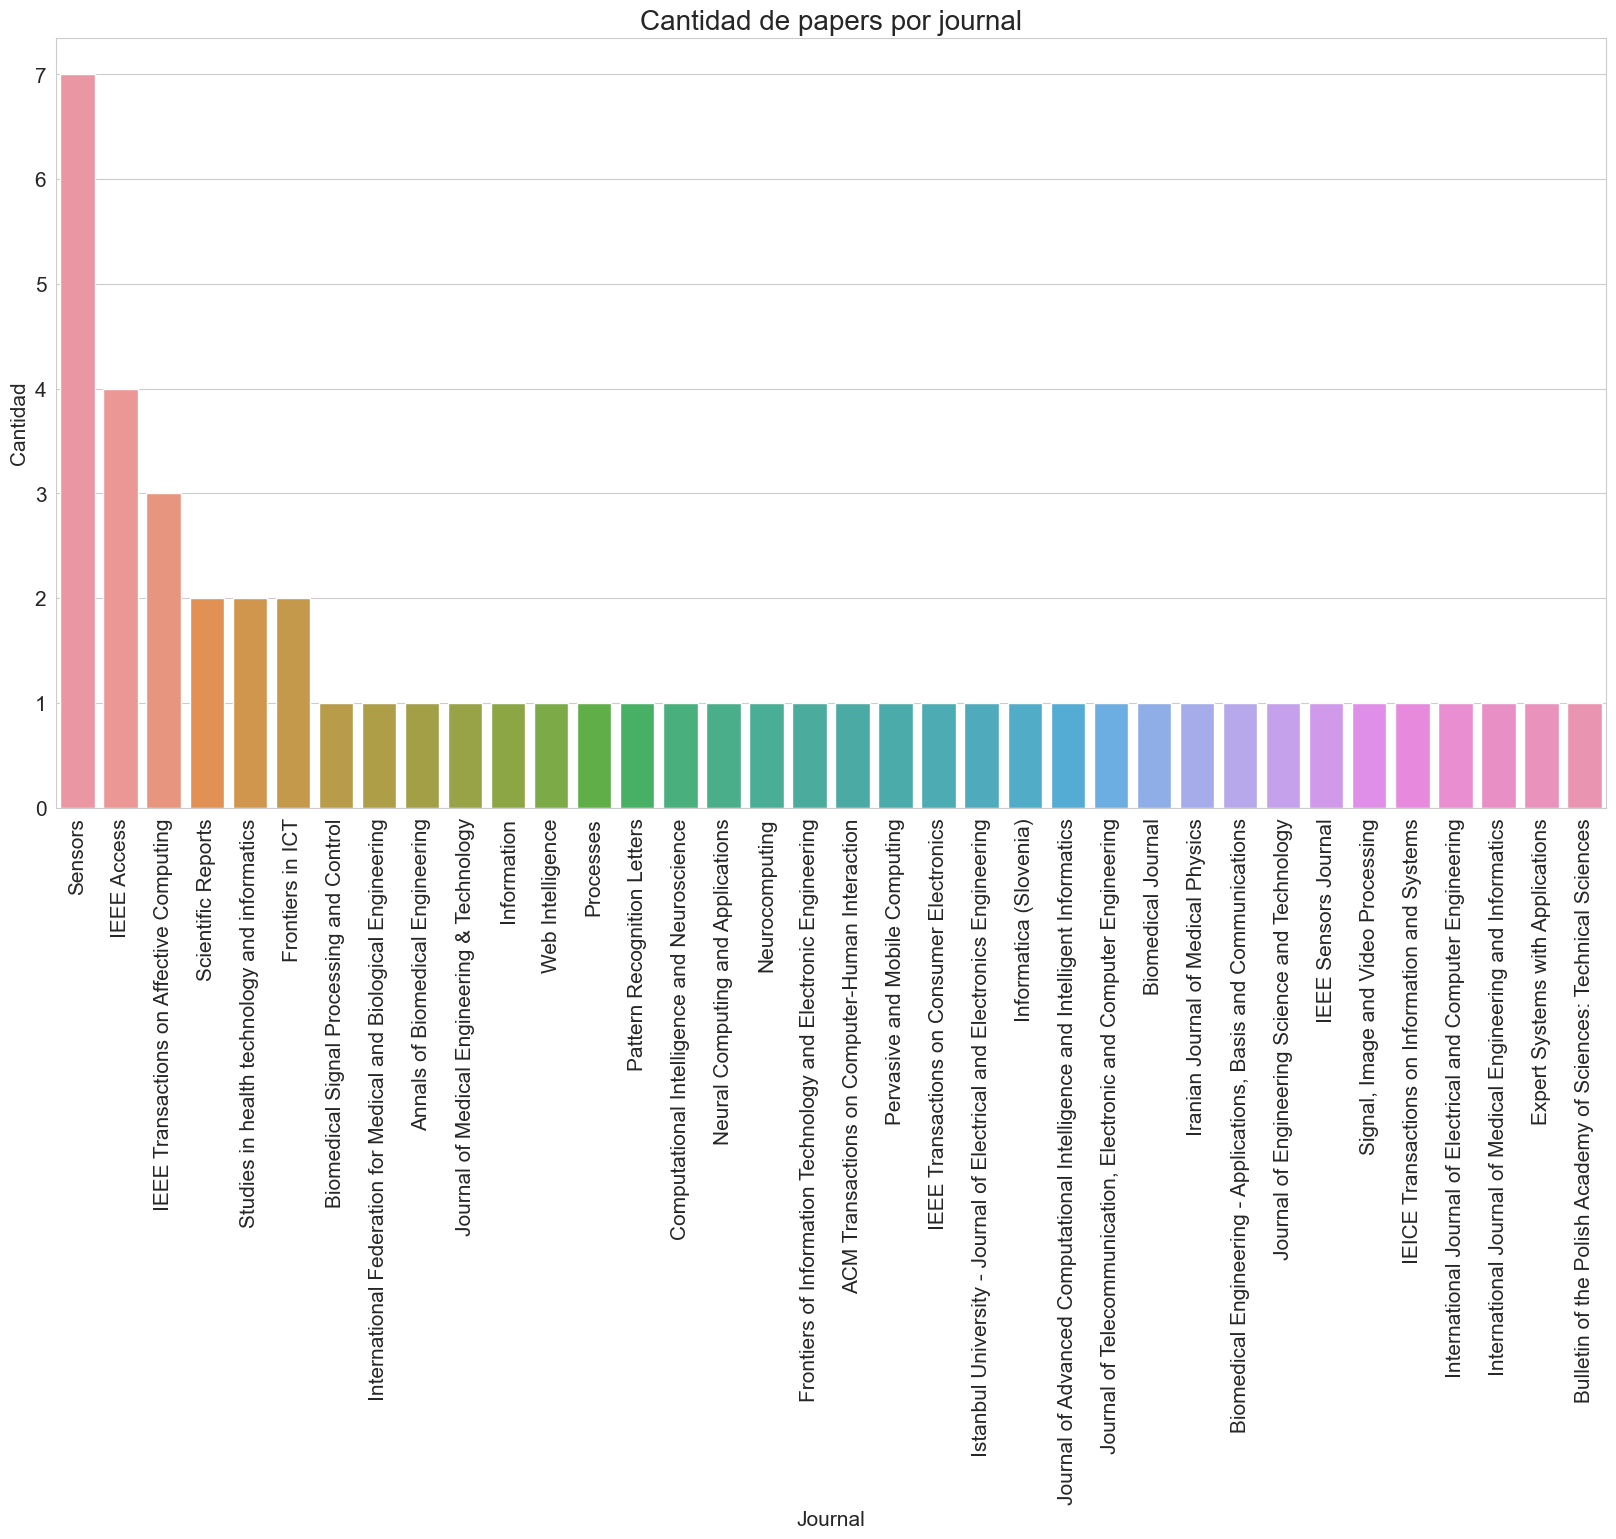

Sensors                                                                       7
IEEE Access                                                                   4
IEEE Transactions on Affective Computing                                      3
Scientific Reports                                                            2
Studies in health technology and informatics                                  2
Frontiers in ICT                                                              2
Biomedical Signal Processing and Control                                      1
International Federation for Medical and Biological Engineering               1
Annals of Biomedical Engineering                                              1
Journal of Medical Engineering & Technology                                   1
Information                                                                   1
Web Intelligence                                                              1
Processes                               

In [266]:
#por revista
df_metadata=df_metadata.fillna('-')
df_metadata_sin_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_source_title = df_metadata_sin_duplicates[['paper_id','source_title','source_type_journal']]
df_source_title = df_source_title[df_source_title['source_type_journal'].isin(['x', 'X'])] 

titulos = ['Cantidad de papers por journal', 'Journal', 'Cantidad']
bar_plot('source_title',df_source_title,titulos)

lista_journals = df_source_title["source_title"].value_counts()
print(lista_journals)

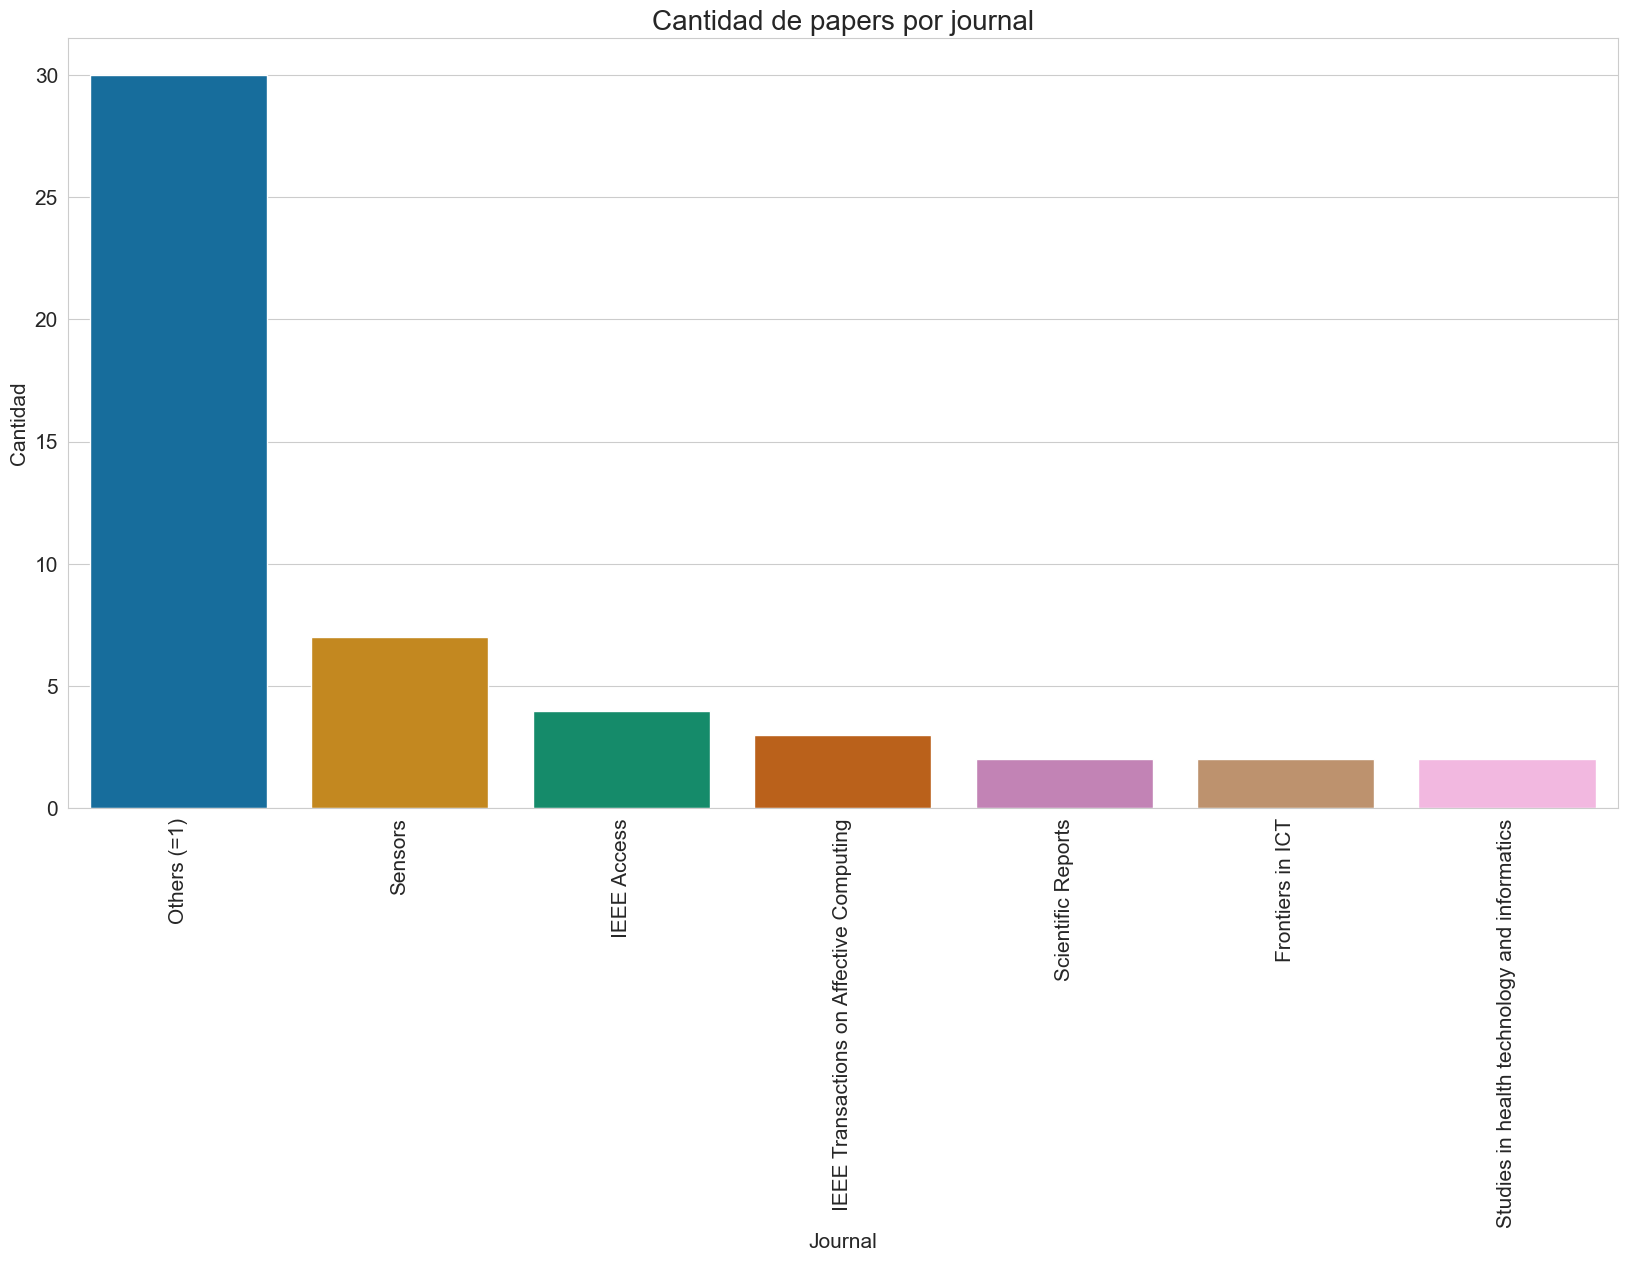

Others (=1)                                     30
Sensors                                          7
IEEE Access                                      4
IEEE Transactions on Affective Computing         3
Scientific Reports                               2
Frontiers in ICT                                 2
Studies in health technology and informatics     2
Name: source_title, dtype: int64


In [267]:
mapping_others ={
        'Biomedical Signal Processing and Control': 'Others (=1)',
        'International Federation for Medical and Biological Engineering': 'Others (=1)',
        'Annals of Biomedical Engineering': 'Others (=1)',
        'Journal of Medical Engineering & Technology': 'Others (=1)',
        'Information': 'Others (=1)',
        'Web Intelligence': 'Others (=1)',
        'Processes': 'Others (=1)',
        'Pattern Recognition Letters': 'Others (=1)',
        'Computational Intelligence and Neuroscience': 'Others (=1)',
        'Neural Computing and Applications': 'Others (=1)',
        'Neurocomputing': 'Others (=1)',
        'Frontiers of Information Technology and Electronic Engineering': 'Others (=1)',
        'ACM Transactions on Computer-Human Interaction': 'Others (=1)',
        'Pervasive and Mobile Computing': 'Others (=1)',
        'IEEE Transactions on Consumer Electronics': 'Others (=1)',
        'Istanbul University - Journal of Electrical and Electronics Engineering': 'Others (=1)',
        'Informatica (Slovenia)': 'Others (=1)',
        'Journal of Advanced Computational Intelligence and Intelligent Informatics': 'Others (=1)',
        'Journal of Telecommunication, Electronic and Computer Engineering': 'Others (=1)',
        'Biomedical Engineering - Applications, Basis and Communications': 'Others (=1)',
        'Biomedical Journal': 'Others (=1)',
        'Iranian Journal of Medical Physics': 'Others (=1)',
        'IEEE Sensors Journal': 'Others (=1)',
        'Journal of Engineering Science and Technology': 'Others (=1)',
        'Signal, Image and Video Processing': 'Others (=1)',
        'IEICE Transactions on Information and Systems': 'Others (=1)',
        'International Journal of Electrical and Computer Engineering': 'Others (=1)',
        'International Journal of Medical Engineering and Informatics': 'Others (=1)',
        'Expert Systems with Applications': 'Others (=1)',
        'Bulletin of the Polish Academy of Sciences: Technical Sciences': 'Others (=1)'}

sources_with_others = df_source_title.copy()
sources_with_others.loc[:,'source_title'] = sources_with_others.loc[:,'source_title'].replace(mapping_others)
sources_with_others['source_title'].value_counts()

titulos = ['Cantidad de papers por journal', 'Journal', 'Cantidad']
bar_plot('source_title',sources_with_others,titulos)

lista_journals_with_other = sources_with_others["source_title"].value_counts()
print(lista_journals_with_other)

## 8. Box plot comparando performance de modelos de arousal y de valencia 

* Las medidas de performance fueron sacadas del analisis estadistico del punto 2 (medidas de performance de modelos de clasificacion, para valencia y arousal, tomando la medida de performance mas frecuente (accuracy))

[Text(0.5, 1.0, 'Comparación performance para modelos de clasificación arousal y valencia, usando accuracy')]

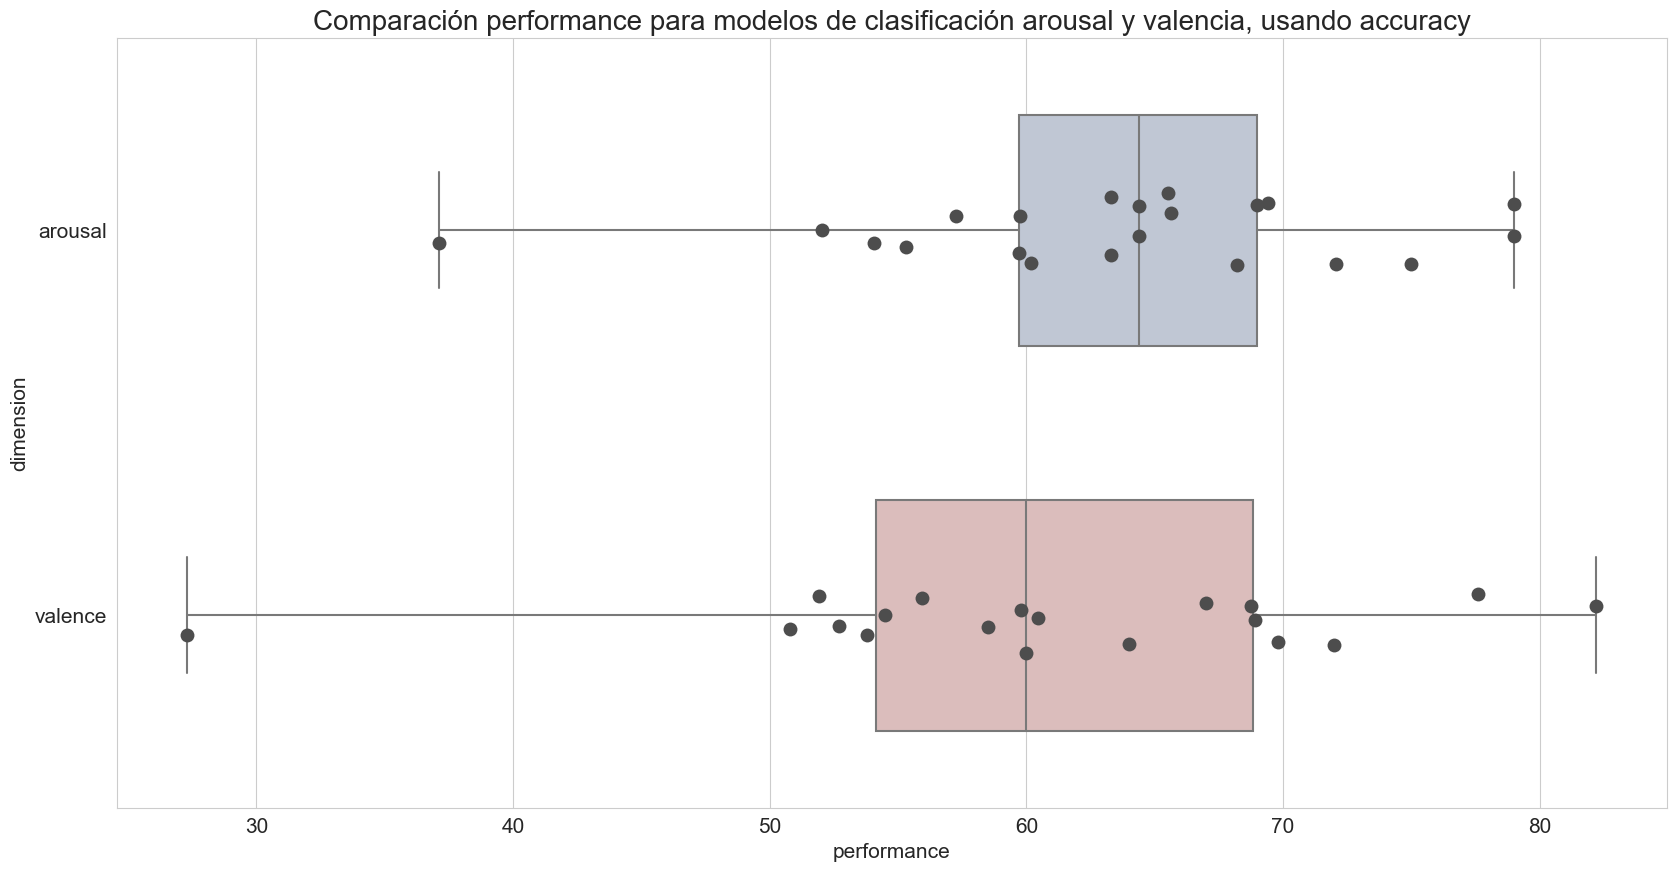

In [268]:
#performances para arousal y valencia
performances_av = pd.read_excel("..\data\cleaned\modelos.xlsx")
performances_av = pd.DataFrame(performances_av)

#plot

g = sns.boxplot(x="performance", y="dimension", data=performances_av,
            whis=[0, 100], width=.6, palette="vlag")

sns.stripplot(x="performance", y="dimension", data=performances_av,
              size=10, color=".3", linewidth=0)

g.set(title = 'Comparación performance para modelos de clasificación arousal y valencia, usando accuracy')


## 9. Node plot, para categorias emocionales

### Primero obtenemos las categorias emocionales usadas y su frecuencia

* Hubo 55 modelos que usaron categorias emocionales, siendo disgust, fear, y sadness las mas repetidas.
* Tener en cuenta que un modelo puede usar mas de una categoria, por lo que la funcion get_values no funciona en este caso, y un paper puede concentrar la mayoria de los usos de un conjunto de categorias

Disgust       114
Fear          114
Sadness       114
Anger          81
Neutral        76
Surprise       75
Anxiety        72
Amusement      44
Joy            40
Happiness      37
Pleasant       33
Relaxation      8
Stress          5
Boredom         3
Funny           1
Name: variable, dtype: int64
['Anger' 'Stress' 'Disgust' 'Fear' 'Sadness' 'Surprise' 'Happiness'
 'Pleasant' 'Anxiety' 'Neutral' 'Funny' 'Boredom' 'Relaxation' 'Amusement'
 'Joy']


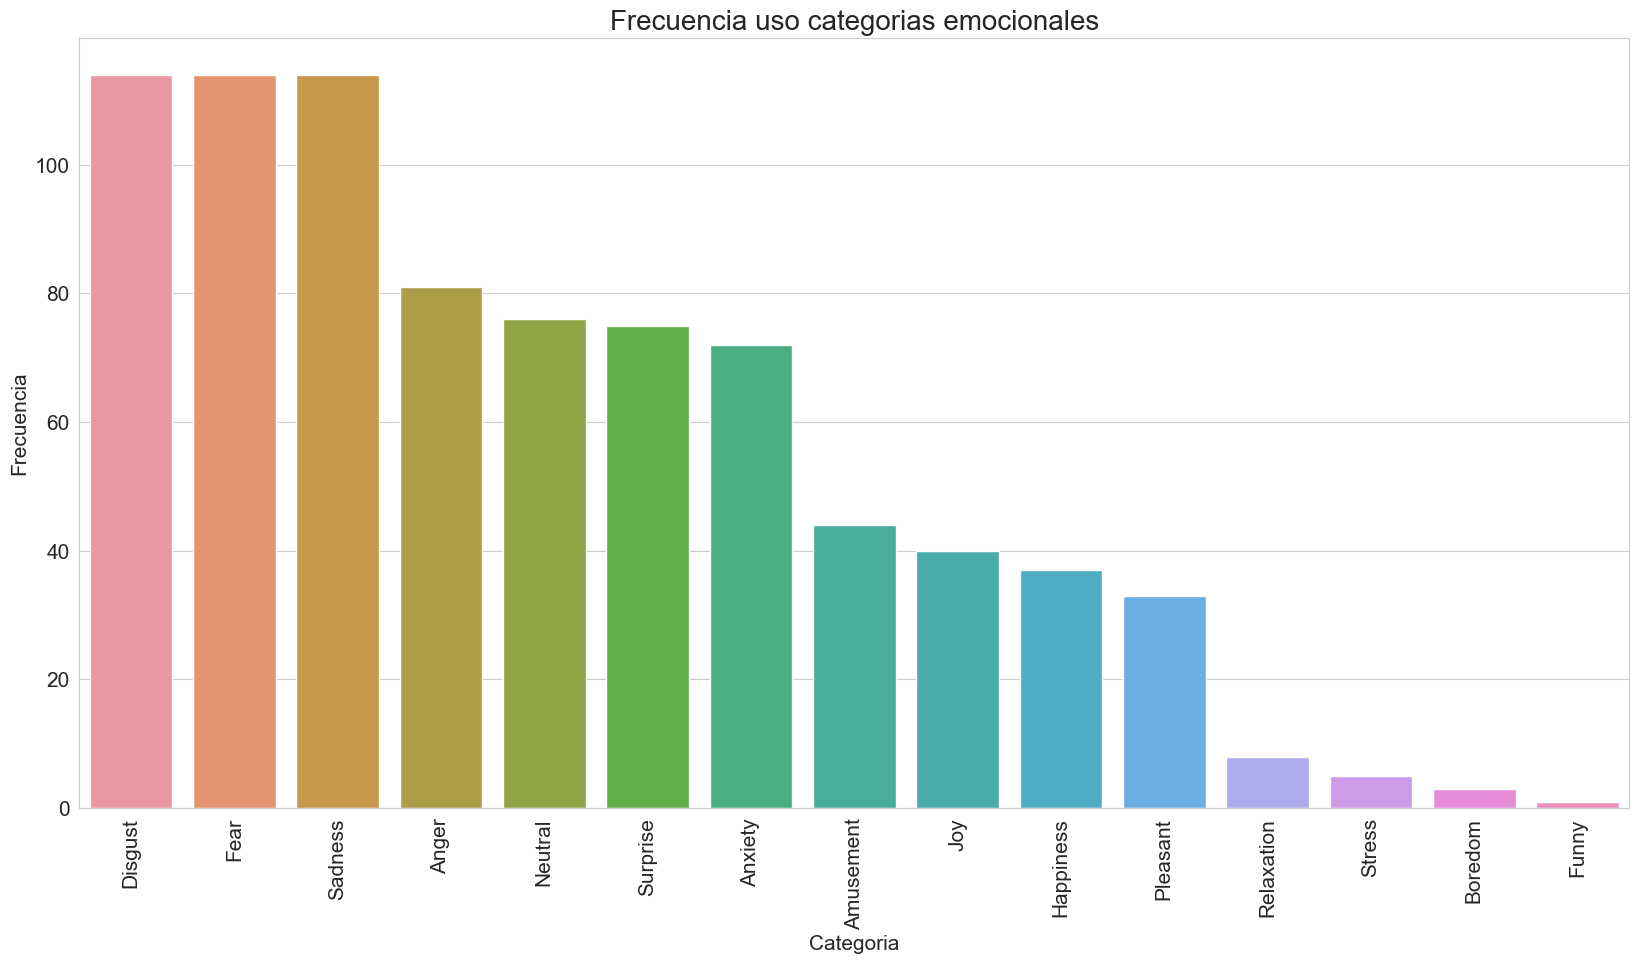

In [269]:
df_self_report=df_self_report.fillna('-')
#df_self_report = df_self_report.drop_duplicates(subset='paper_id')
df_self_report = df_self_report[df_self_report['is_categorial'].isin(['x', 'X'])]

emotional_categories = multi_reversing(df_self_report, 'model_id', df_self_report.iloc[:,19:])

print(emotional_categories['variable'].value_counts())
print(emotional_categories['variable'].unique())

titulos = ['Frecuencia uso categorias emocionales', 'Categoria', 'Frecuencia']
bar_plot('variable',emotional_categories,titulos)

### Creamos el grafo
* Vemos que las categorias de stress, joy y relaxation no se han usado junto a otras para la prediccion de emociones
* disgust, fear, sadness y neutral son las que tienen mas conexiones (8), seguidas por anger, surprise y happiness (6), pleasent y anxiety (4), y funny y boredom (1)
* falta customizar el tamaño de las lineas, segun la cantidad de veces que ambas categorias fueron testeadas juntas
* siguiendo con lo anterior, tener en cuenta que, a pesar de lo mencionado,disgust fear y sadnes han sido las categorias mas utilizadas en modelos (apareciendo en 35), seguidas de cerca por pleasent y anxiety (cerca de 35 cada una). 
* Neutral, por ejemplo, se ha testeado solo en 4 modelos, pero ha aparecido en total junto a otras 8 categorias. Pleasent y anxiety han aparecido solo con otras 4 categorias, pero fueron testeadas cerca de 35 veces cada una.

In [270]:
#creacion matrix de adyacencia
df_self_report.fillna('-', inplace= True)
self_0 = df_self_report[df_self_report['is_categorial']!= '-']

df_matrix_con_paperid_0 = self_0.groupby(
        ['paper_id','Anger',
        'Stress', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Happiness',
        'Pleasant', 'Unpleasant', 'Anxiety', 'Neutral', 'Funny', 'Horror',
        'Weepy', 'Boredom', 'Relaxation', 'Amusement', 'Confusion', 'Curiosity',
        'Delight', 'flow/engagement', 'Frustration', 'Tenderness', 'Joy']
        ).nth(0)
df_matrix_con_paperid_0.reset_index(inplace=True)

df_matrix = df_matrix_con_paperid_0[
        ['Anger',
        'Stress', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Happiness',
        'Pleasant', 'Unpleasant', 'Anxiety', 'Neutral', 'Funny', 'Horror',
        'Weepy', 'Boredom', 'Relaxation', 'Amusement', 'Confusion', 'Curiosity',
        'Delight', 'flow/engagement', 'Frustration', 'Tenderness', 'Joy']
        ]

df_matrix = df_matrix.replace('-', 0)
df_matrix = df_matrix.replace('x', 1)
adj_matrix = df_matrix.T.dot(df_matrix)
np.fill_diagonal(adj_matrix.values, 0)

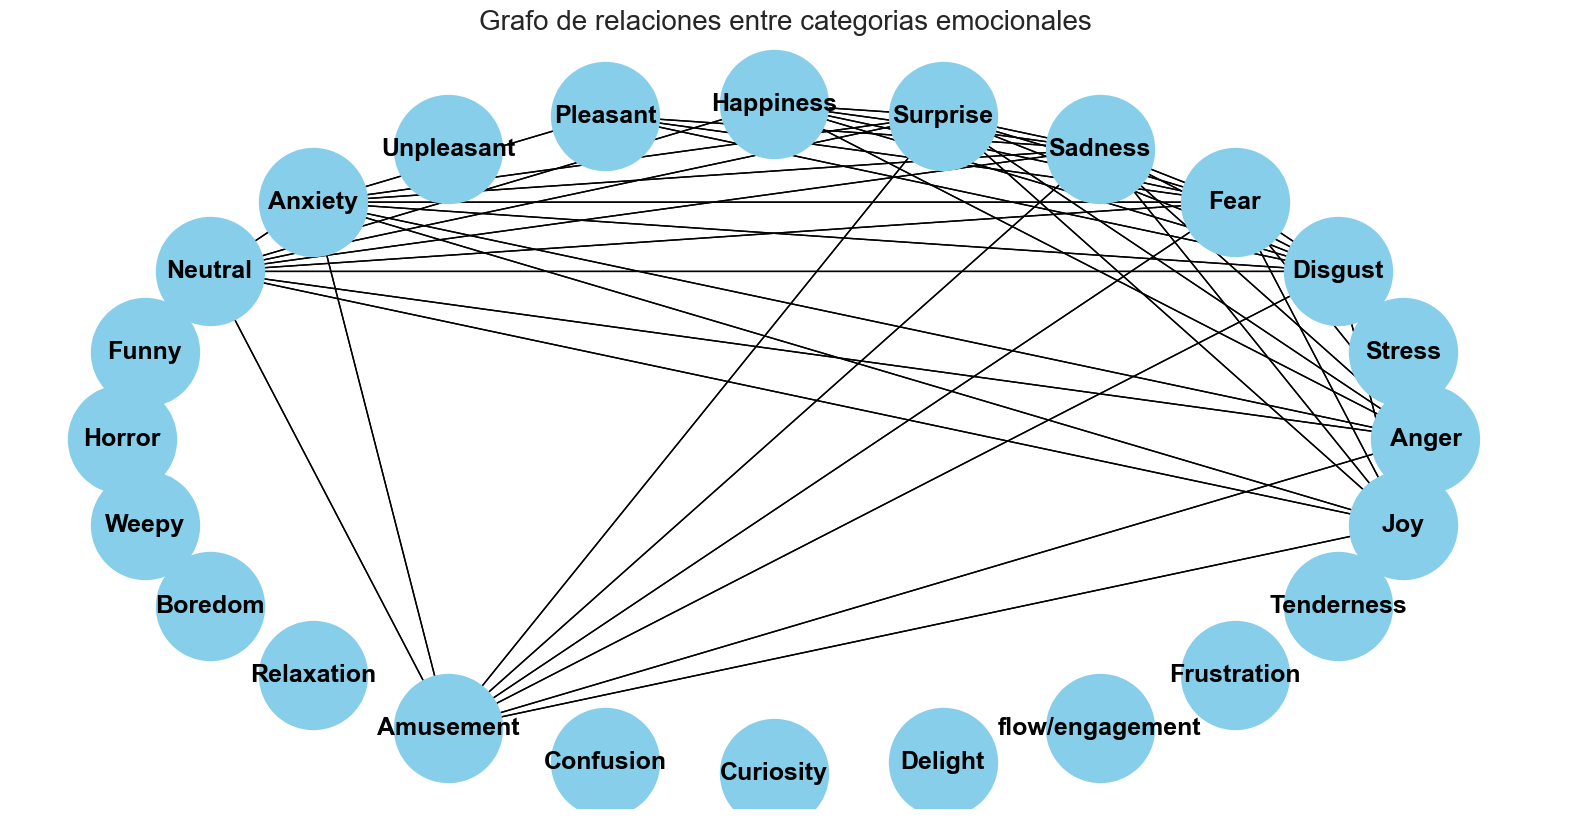

In [275]:
G = nx.DiGraph(adj_matrix)

plt.title('Grafo de relaciones entre categorias emocionales')
g = nx.draw_circular(G, with_labels=True, node_size=1500, node_color="skyblue", linewidths=40,
                    font_size=18, font_color="black", font_weight="bold", width=1)

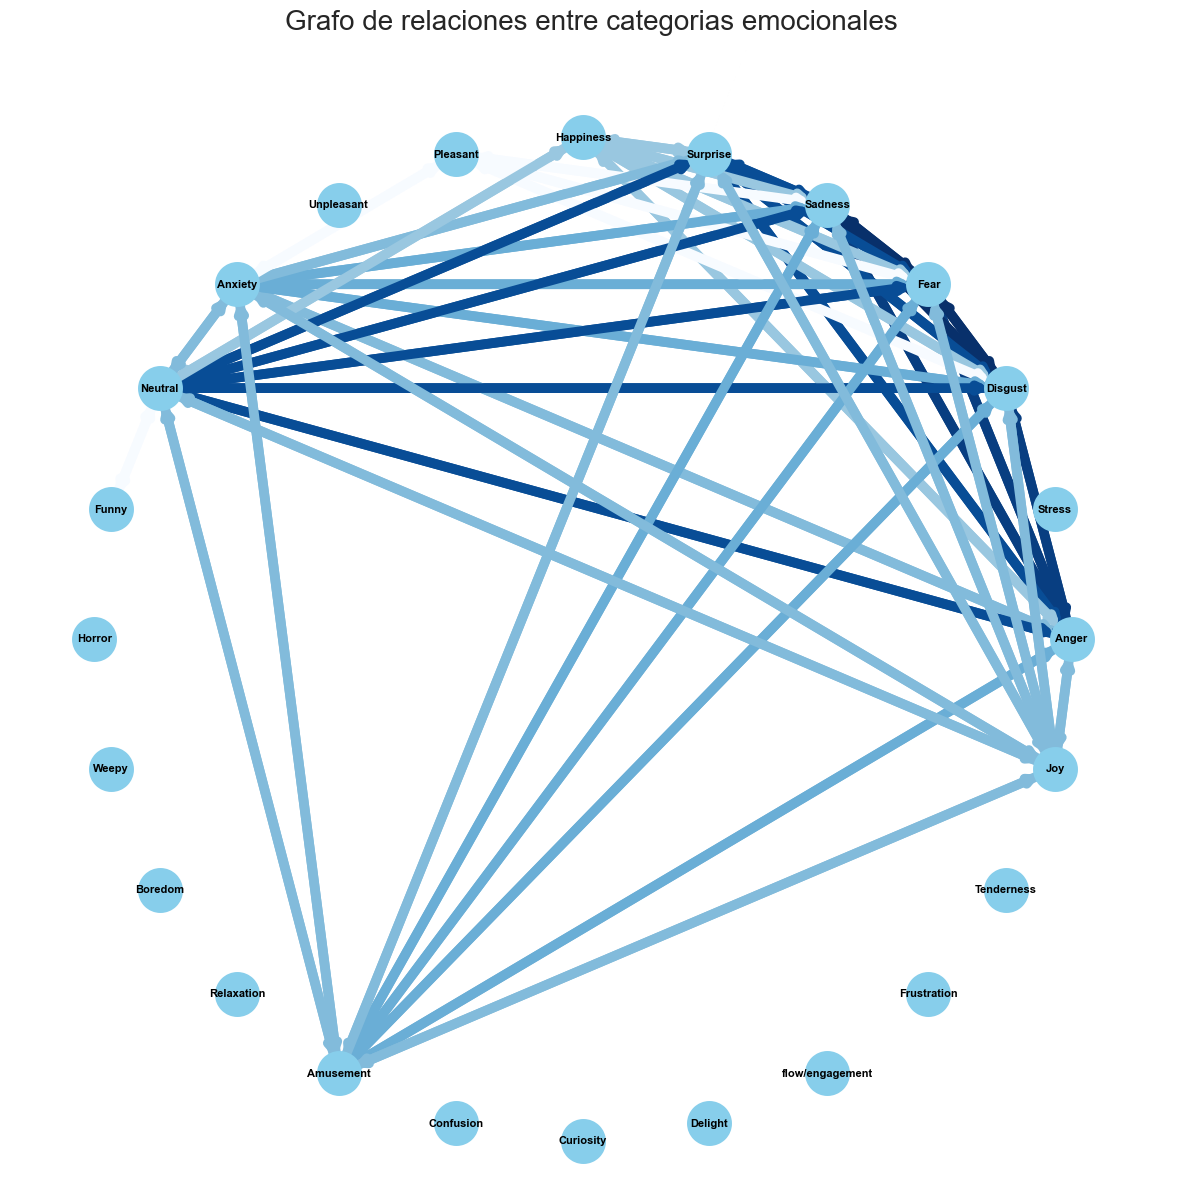

In [298]:
G = nx.DiGraph(adj_matrix)


labels=nx.get_edge_attributes(G, "weight")
weights=[wt for u, v, wt in G.edges(data="weight")]
plt.figure(figsize=(15,15))
plt.title('Grafo de relaciones entre categorias emocionales')

g = nx.draw_circular(G, with_labels=True, node_size=500, node_color="skyblue",edge_color=weights,edge_cmap=plt.cm.Blues,linewidths=10,
                    font_size=8, font_color="black", font_weight="bold", width=7) # el arrow no me funcionó

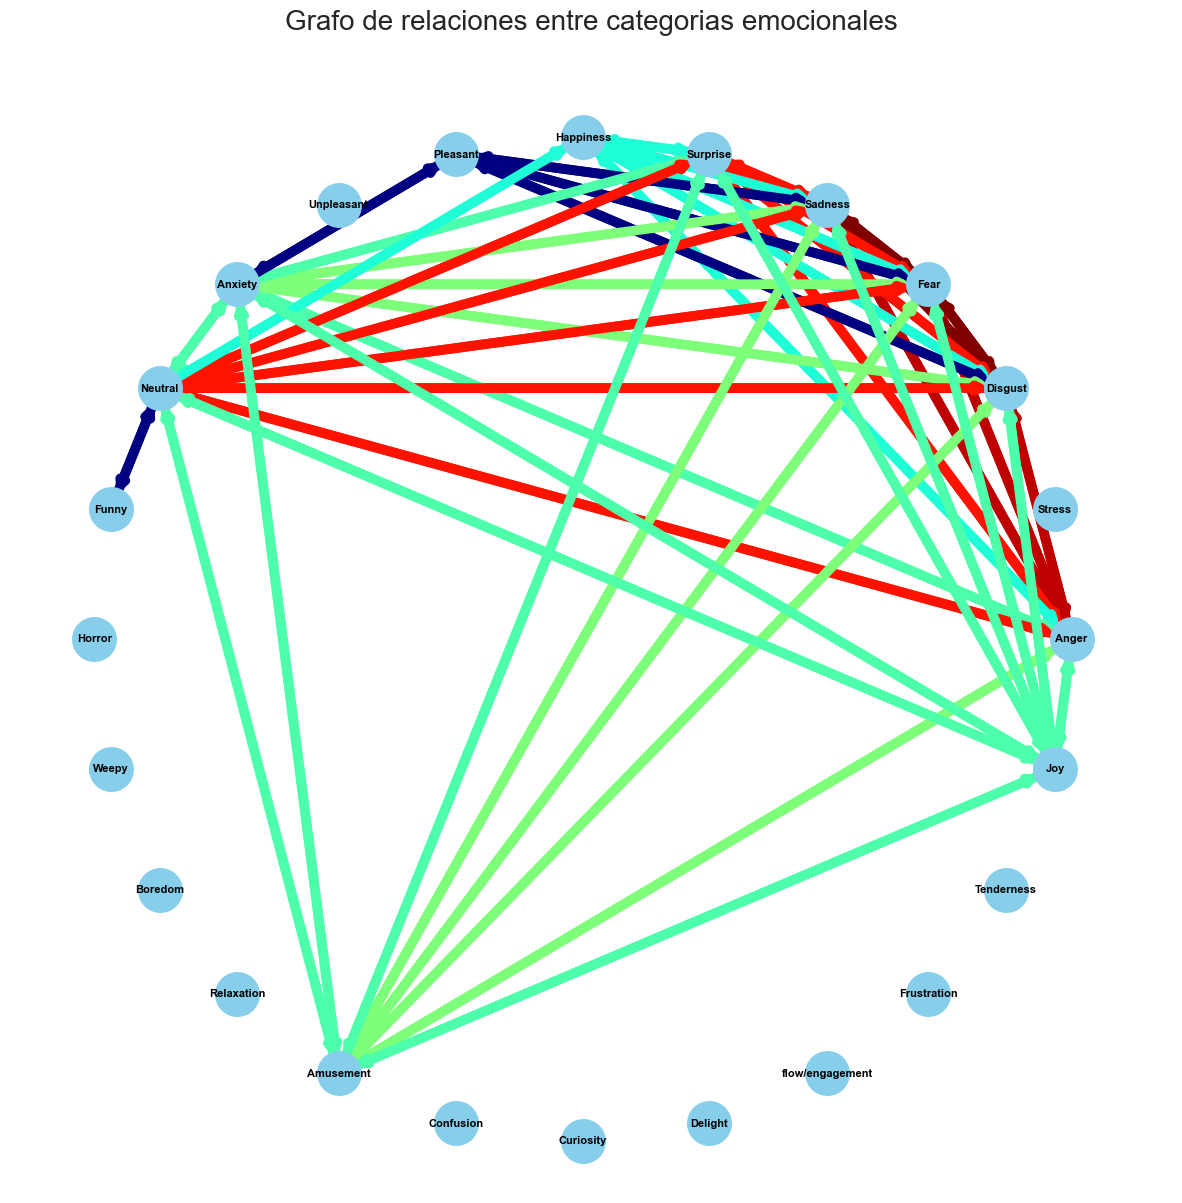

In [300]:
#Las relaciones fuertes en rojo, las debiles en azul
G = nx.DiGraph(adj_matrix)

import matplotlib.colors as colors
import matplotlib.cm as cmx

labels=nx.get_edge_attributes(G, "weight")
weights=[wt for u, v, wt in G.edges(data="weight")]
colours = "red"
values = range(35)
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
colorList = []

for i in range(35):
    colorVal = scalarMap.to_rgba(values[i])
    colorList.append(colorVal)

plt.figure(figsize=(15,15))
plt.title('Grafo de relaciones entre categorias emocionales')


g = nx.draw_circular(G, with_labels=True, node_size=500, node_color="skyblue",edge_color=weights,edge_cmap=plt.cm.jet,linewidths=10,
                    font_size=8, font_color="black", font_weight="bold", width=7)

{('Anger', 'Disgust'): Text(0.9330126949577691, 0.24999999803401166, '18'),
 ('Anger', 'Fear'): Text(0.8535533863730931, 0.35355338128202757, '18'),
 ('Anger', 'Sadness'): Text(0.7499999882239161, 0.4330127196690256, '18'),
 ('Anger', 'Surprise'): Text(0.6294095413518174, 0.4829629014825296, '17'),
 ('Anger', 'Happiness'): Text(0.4999999843944604, 0.4999999949089345, '8'),
 ('Anger', 'Anxiety'): Text(0.14644662612721548, 0.35355338128202757, '9'),
 ('Anger', 'Neutral'): Text(0.0669873175425395, 0.2500000278363337, '17'),
 ('Anger', 'Amusement'): Text(0.2500000540787145, -0.43301271735084795, '10'),
 ('Anger', 'Joy'): Text(0.9829629363759171, -0.12940941473328618, '9'),
 ('Disgust', 'Anger'): Text(0.9330126949577691, 0.24999999803401166, '18'),
 ('Disgust', 'Fear'): Text(0.786566081330862, 0.6035533781569504, '19'),
 ('Disgust', 'Sadness'): Text(0.6830126831816852, 0.6830127165439485, '19'),
 ('Disgust', 'Surprise'): Text(0.5624222363095863, 0.7329628983574524, '17'),
 ('Disgust', 'Happ

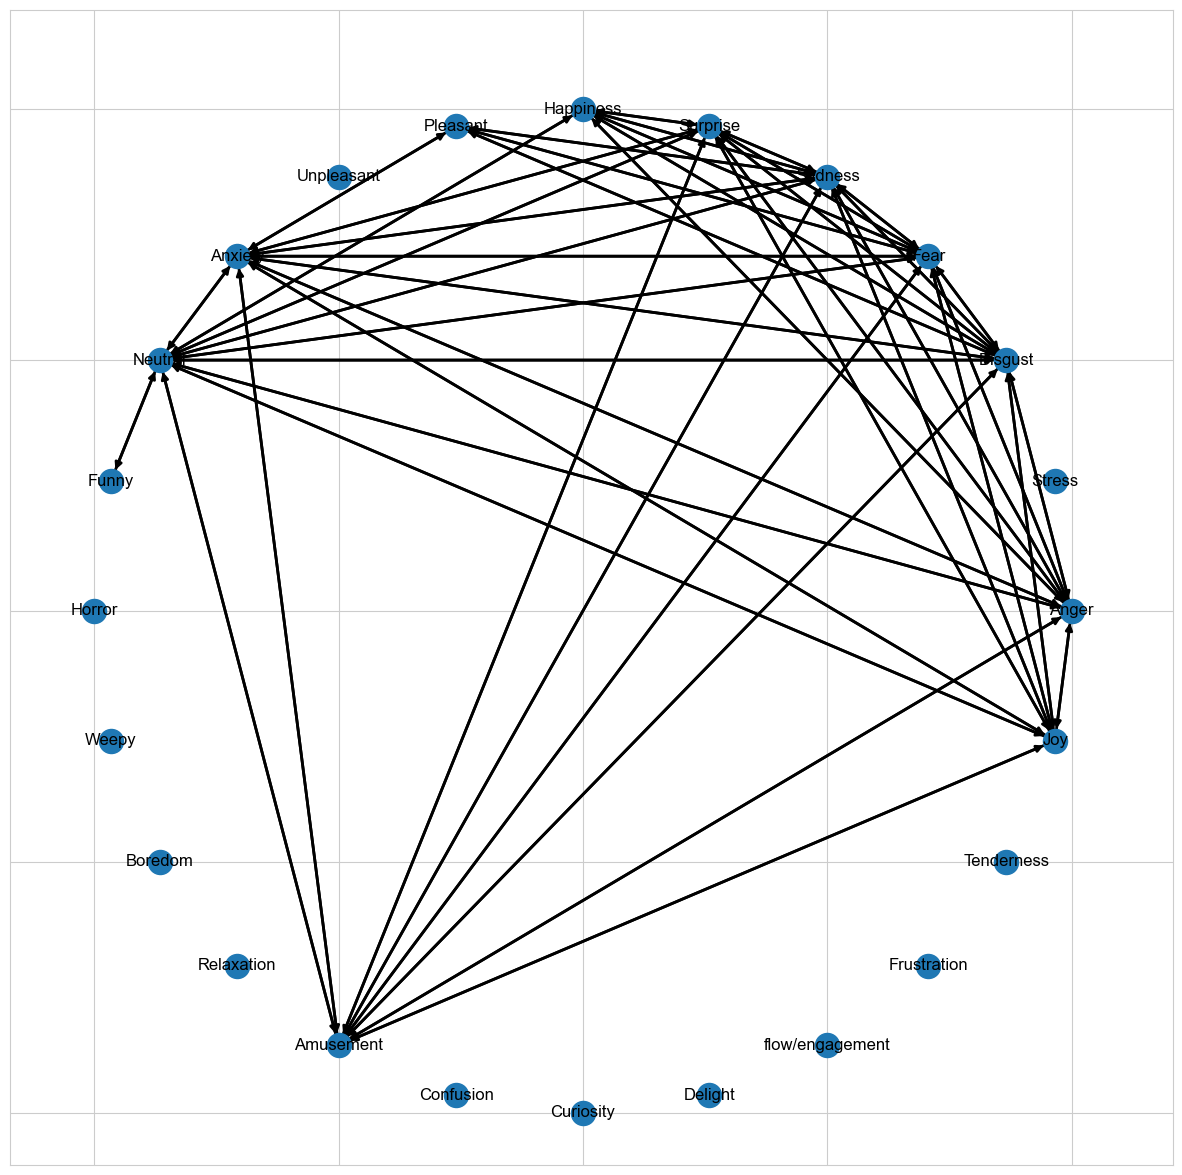

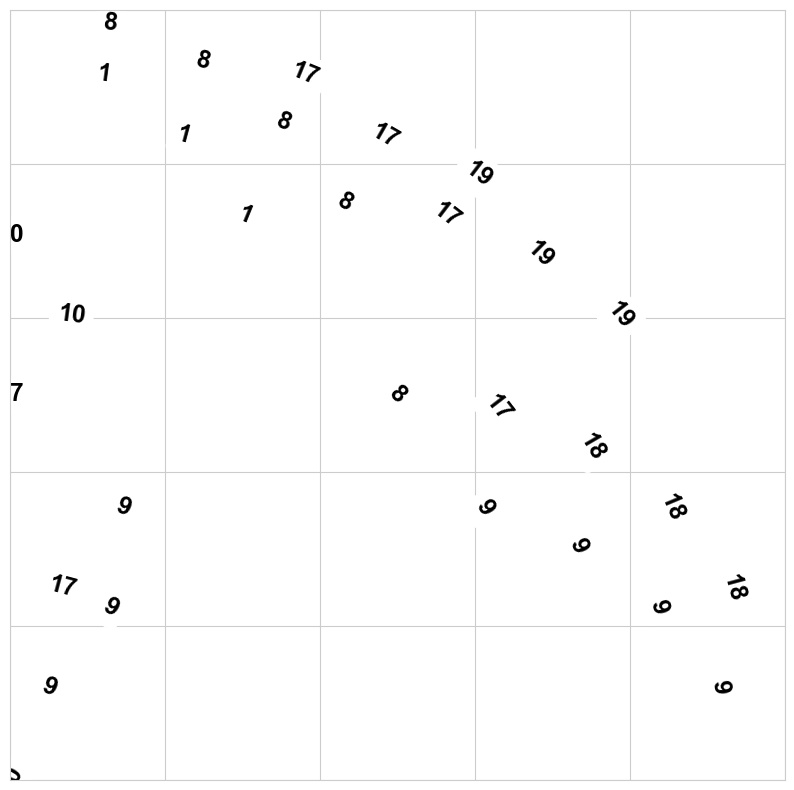

In [279]:
G.number_of_edges()
pos=nx.circular_layout(G)
weights=[wt for u, v, wt in G.edges(data="weight")]

plt.figure(figsize=(15,15))
nx.draw_networkx(G,pos,width=2)
labels=nx.get_edge_attributes(G, "weight") # entiendo que esto te permite poner la cantidad de frecuencia de cada relación con una etiqueta 
#plt.title('Grafo de relaciones entre categorias emocionales')
plt.figure(figsize=(10,10))
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=18, font_color="black", font_weight="bold")

## 10. EDA

In [280]:
df_eda = df_eda.fillna('-')
df_eda_sin_duplicates = df_eda.drop_duplicates(subset='paper_id')

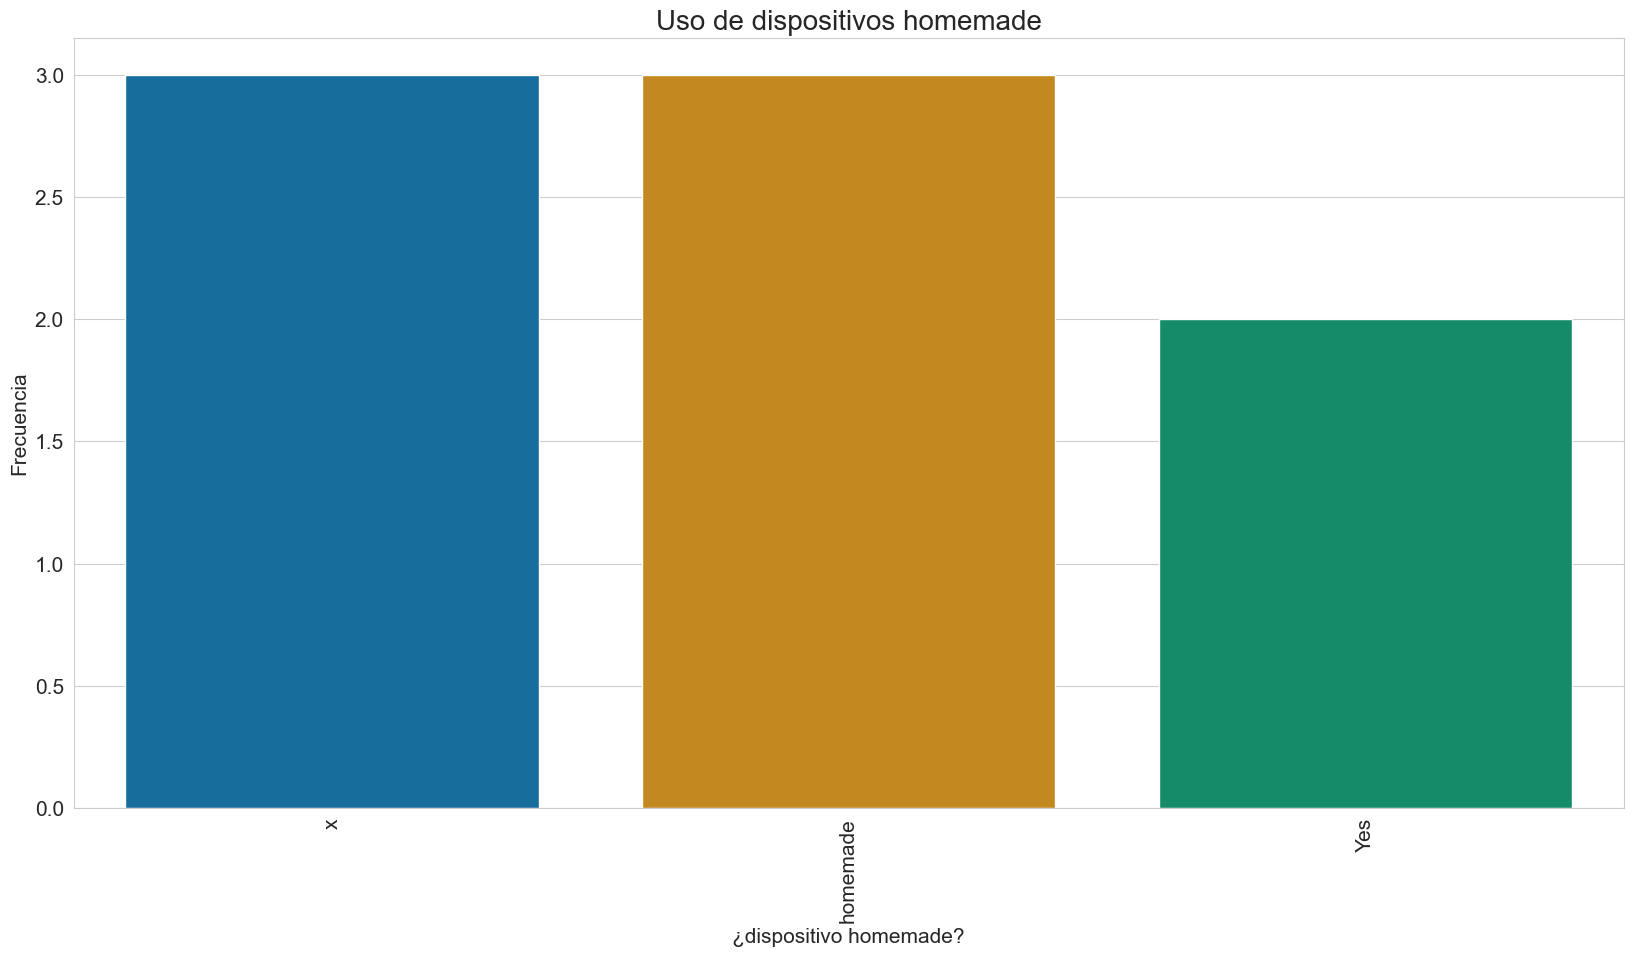

In [281]:
#dispositivos homemade
homemade_dev = pd.DataFrame(df_eda_sin_duplicates['eda_device_is_homemade'])
homemade_dev = homemade_dev[homemade_dev['eda_device_is_homemade'] != '-']
homemade_dev = homemade_dev[homemade_dev['eda_device_is_homemade'] != 'No']
#print(homemade_dev['eda_device_is_homemade'].value_counts())

titulos = ['Uso de dispositivos homemade', '¿dispositivo homemade?', 'Frecuencia']
bar_plot('eda_device_is_homemade',homemade_dev,titulos)

) missing from current font.ng\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


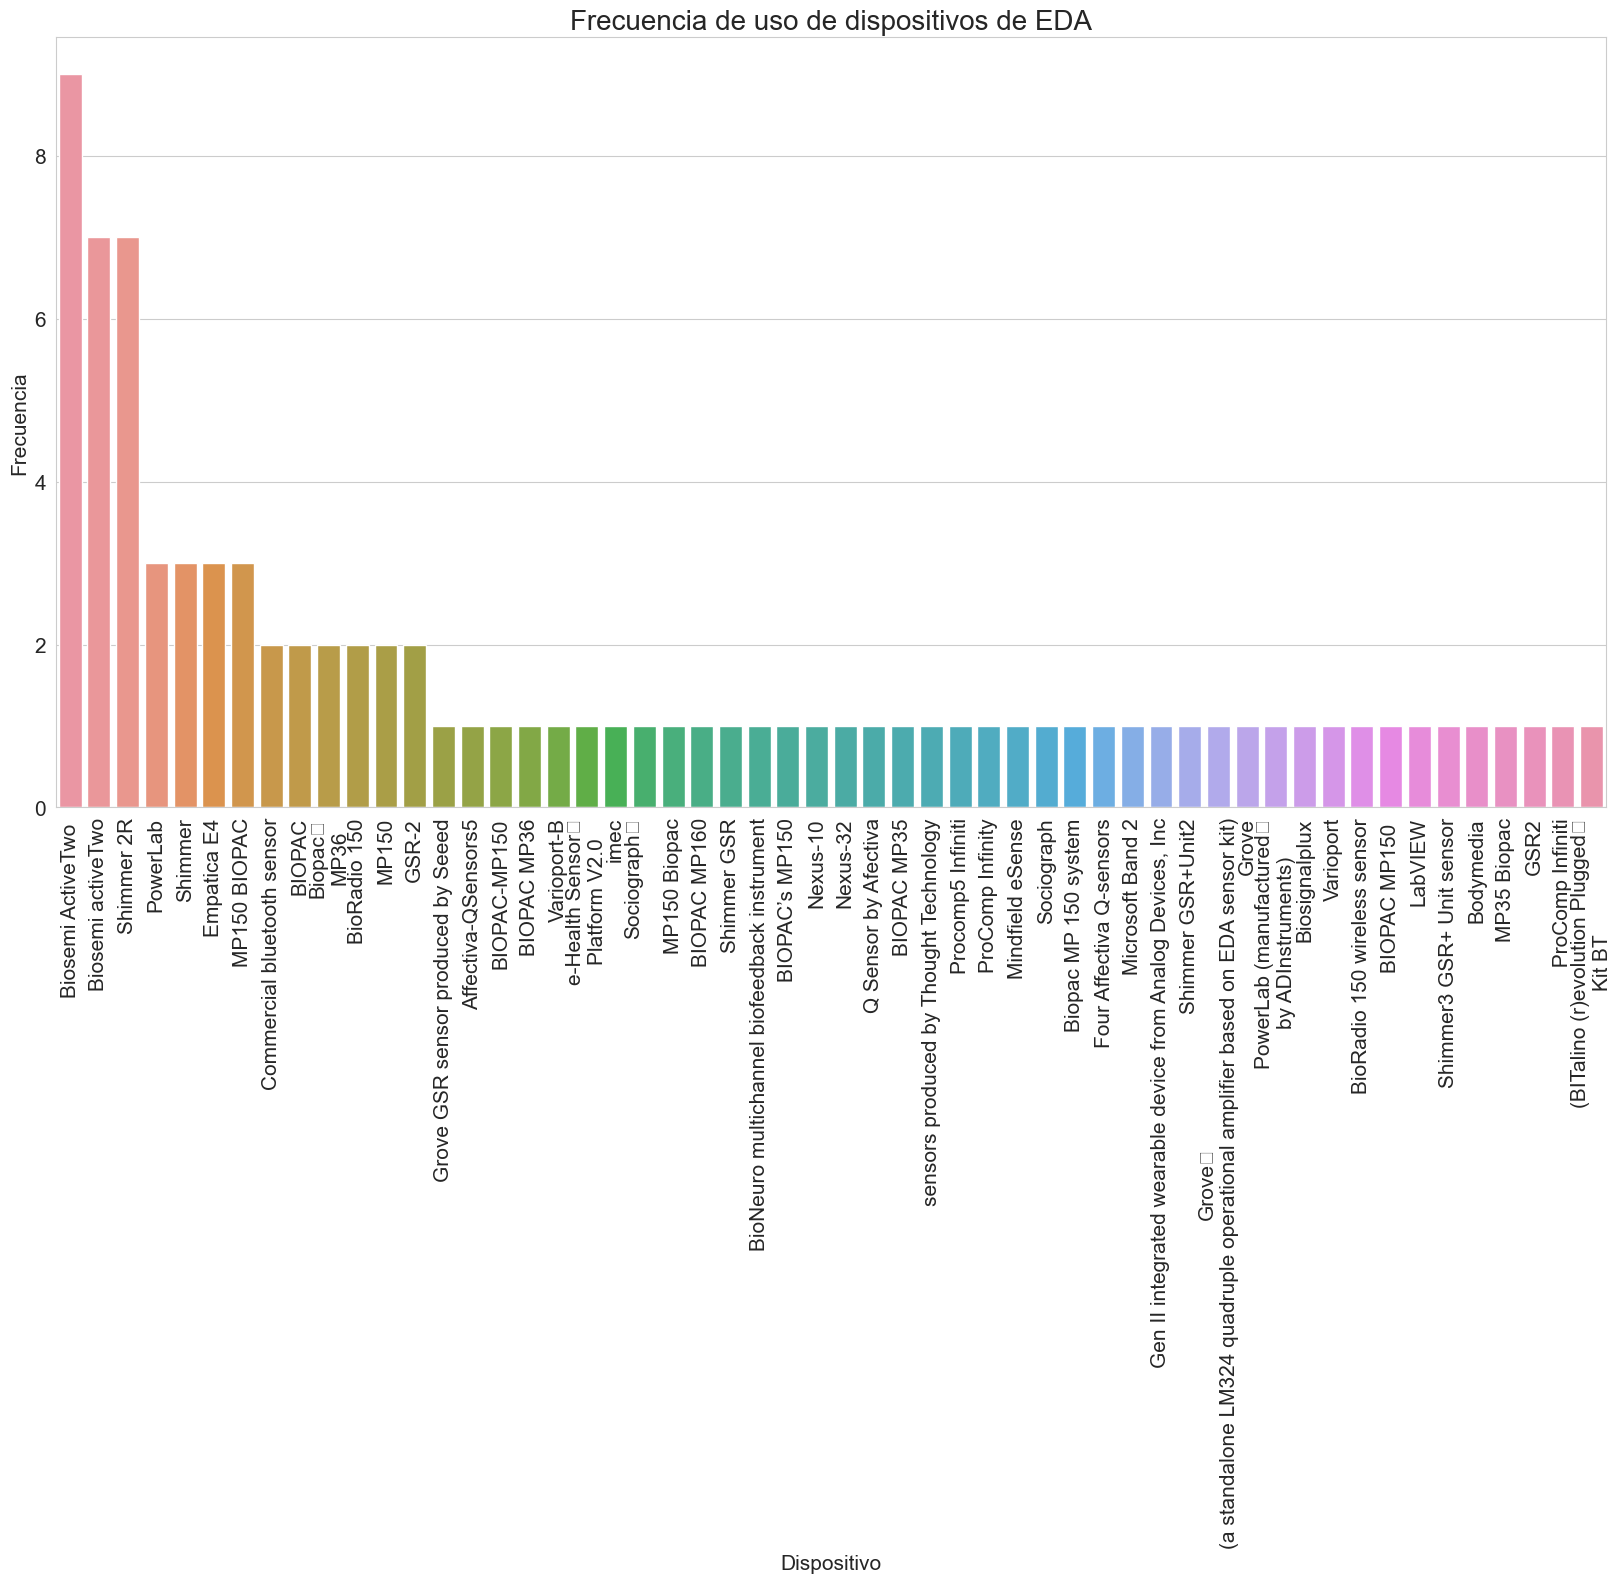

In [282]:
#dispositivos de eda usados
device = pd.DataFrame(df_eda_sin_duplicates['eda_device_specification'])
device = device[device['eda_device_specification'] != '-']
#print(device['eda_device_specification'].value_counts())

titulos = ['Frecuencia de uso de dispositivos de EDA', 'Dispositivo', 'Frecuencia']
bar_plot('eda_device_specification',device,titulos)

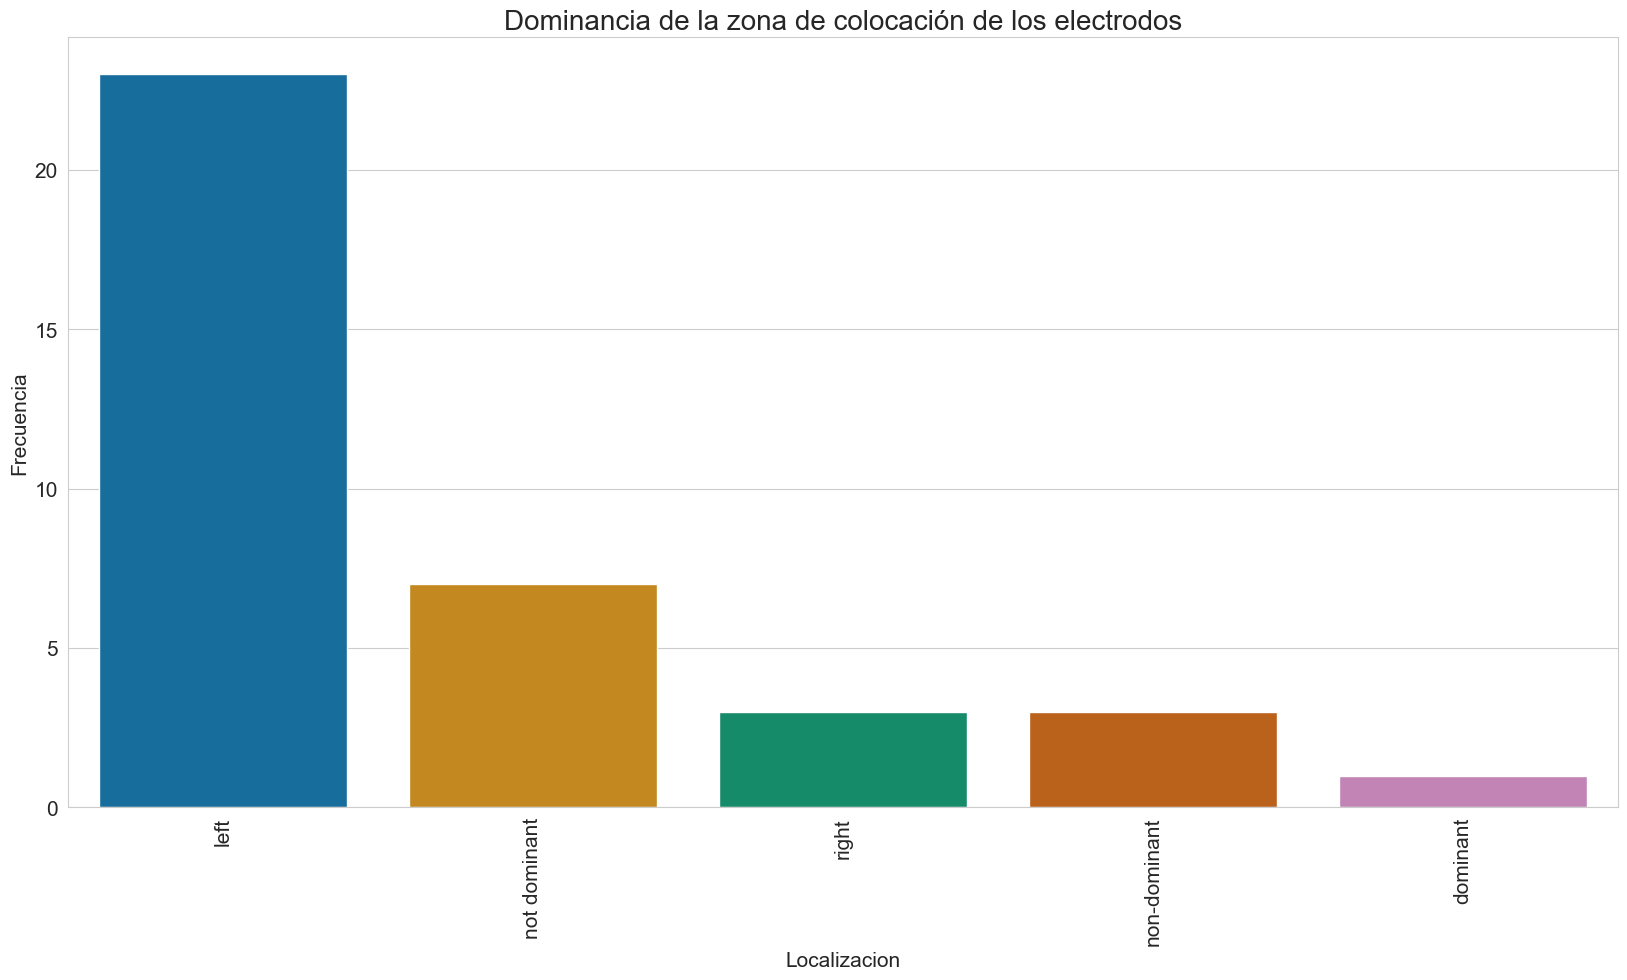

In [283]:
#locaciones usadas
hemibody = pd.DataFrame(df_eda_sin_duplicates['location_hemibody'])
hemibody = hemibody[hemibody['location_hemibody'] != '-']
#print(location['location_hemibody'].value_counts())

titulos = ['Dominancia de la zona de colocación de los electrodos', 'Localizacion', 'Frecuencia']
bar_plot('location_hemibody',hemibody,titulos)

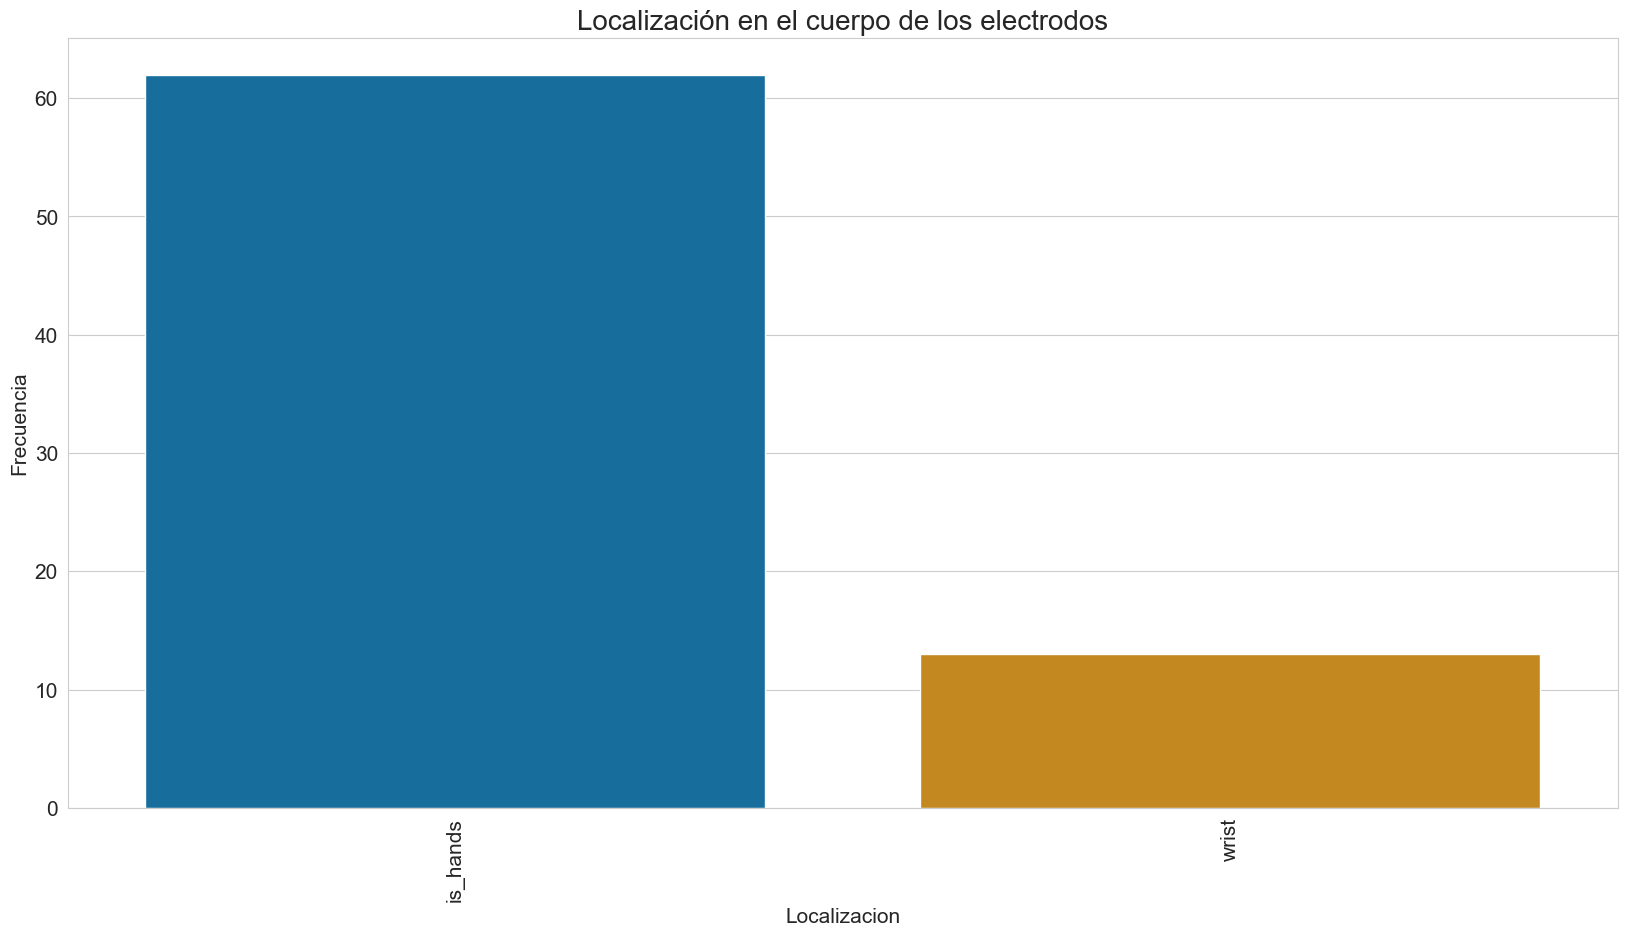

In [284]:
localization = pd.DataFrame(df_eda_sin_duplicates[['is_hands', 'wrist', 'chest','left_lobe_temporalis']])
df_localization = multi_reversing(df_eda_sin_duplicates,'paper_id',df_eda_sin_duplicates[['is_hands', 'wrist', 'chest','left_lobe_temporalis']])

titulos = ['Localización en el cuerpo de los electrodos', 'Localizacion', 'Frecuencia']
bar_plot('variable',df_localization,titulos)

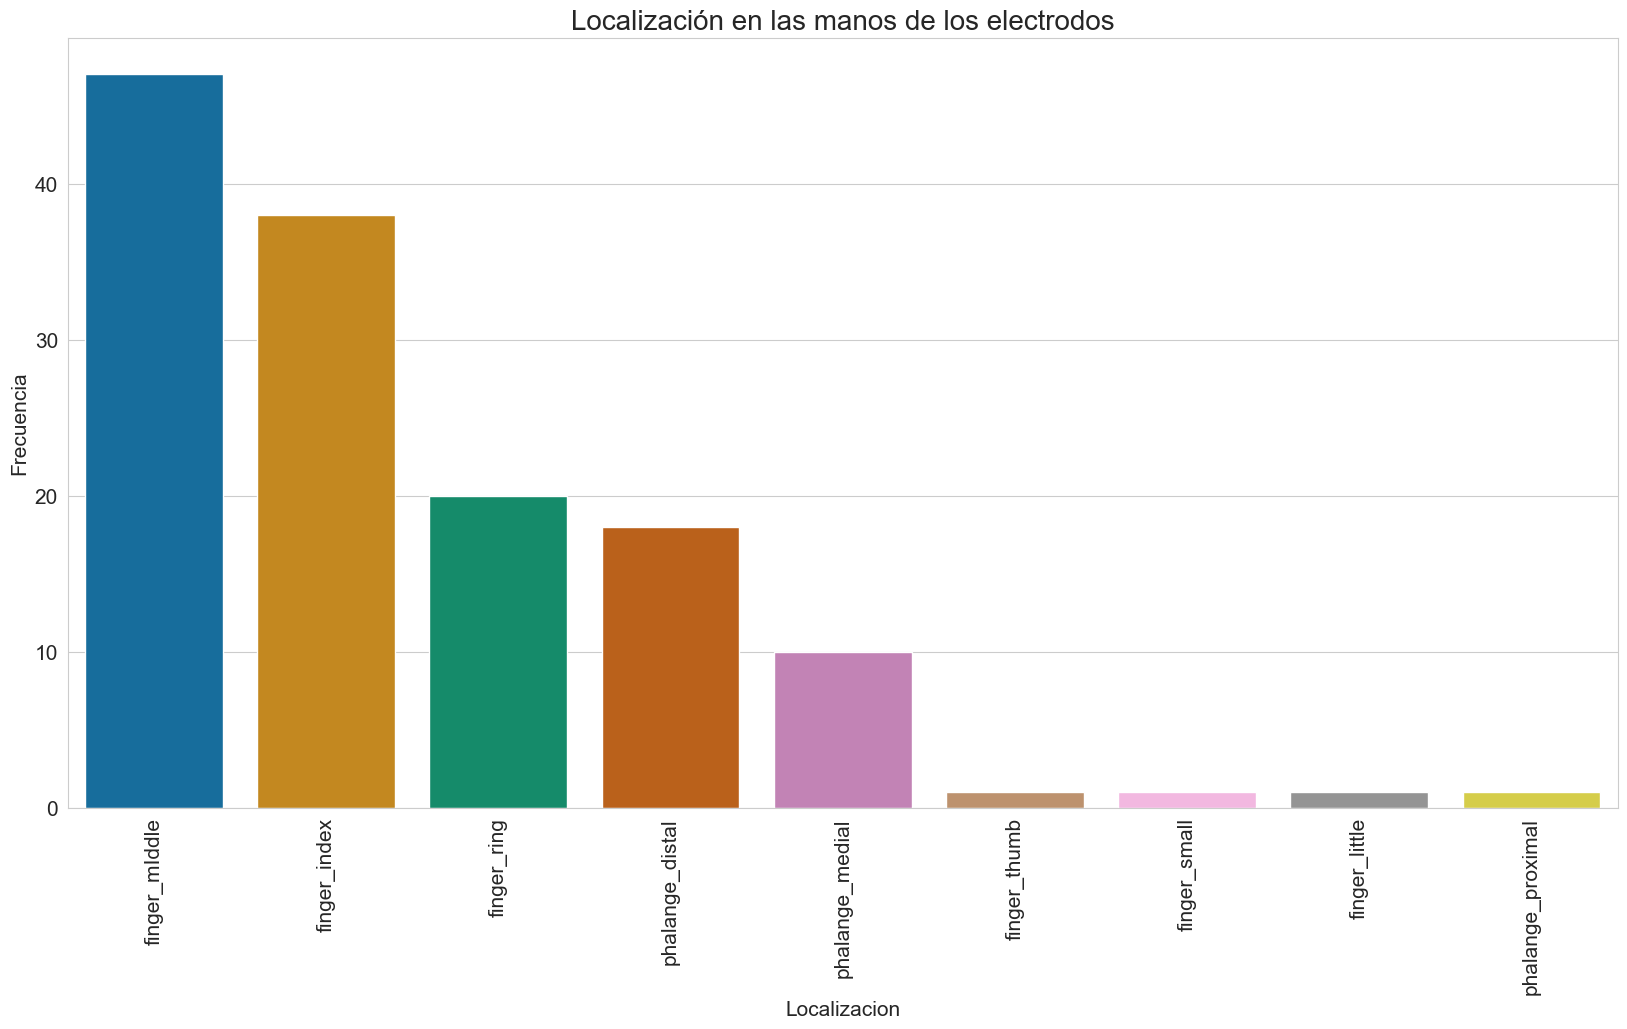

In [285]:


hand_localization = pd.DataFrame(df_eda_sin_duplicates.iloc[:,7:16])
df_hand_localization = multi_reversing(df_eda_sin_duplicates,'paper_id',df_eda_sin_duplicates.iloc[:,7:16])

titulos = ['Localización en las manos de los electrodos', 'Localizacion', 'Frecuencia']
bar_plot('variable',df_hand_localization,titulos)